In [1]:
#Import libraries necessary for this project
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import pearsonr  #calculate the Pearson's correlation between two variables
from scipy.stats import kurtosis, kurtosistest #test the 'tailedness' of probability distribution of variable
from scipy.stats import skew, skewtest #test the skewness of distribution of variables
import datetime
import itertools
from datetime import datetime
import calendar
import matplotlib.dates as mdates
import statistics
import pylab
from itertools import chain
from statsmodels.tsa.seasonal import seasonal_decompose
from tqdm import tnrange, tqdm_notebook #tqdm for the progress bar
pd.options.display.max_columns = None

#sklearn package for modeling
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from statsmodels.stats.outliers_influence import variance_inflation_factor #check VIF score for multicollinearity detection
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.feature_selection import RFECV #Recursive Feature Elimination with Cross-Validation (RFECV)
from sklearn.linear_model import LinearRegression #Linear Regression Model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso #Lasso Regression
from sklearn.linear_model import Ridge #Ridge Regression
from sklearn.neighbors import KNeighborsRegressor #k-Nearest Neighbors
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor #Random Forest Model
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV #perform hyperparameter tuning of k-fold cv with a range of different regularization parameters in order to find the optimal value of alpha for fitting Ridge & Lasso Regression
from sklearn.model_selection import KFold #Evaluating model using K-Fold Cross Validation
from sklearn.model_selection import cross_val_score

#visualization package
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Create feature matrix with Patsy and StatsModels
import patsy

#Suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Display 100 rows at maximum
pd.set_option('display.max_rows', 100)

#read csv into dataframe
listings = pd.read_csv('listings.csv')

print('We have {} properties in the listing dataset, containing {} features.'.format(listings['id'].nunique(), listings.shape[1]))

We have 11248 properties in the listing dataset, containing 109 features.


# (1) Removing irrelevant and redundant columns

In [3]:
#Drop freeform text, url and scraping identifier columns
irrelevant_cols = ['listing_url', 'scrape_id', 'name', 'summary', 'space',
                   'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access',
                   'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url',
                   'xl_picture_url', 'host_url', 'host_name', 'host_location',
                   'host_about', 'host_thumbnail_url', 'host_picture_url',
                   'calendar_updated', 'calendar_last_scraped']

#Drop legal-related columns
legal_cols = ['requires_license', 'license', 'jurisdiction_names']

#Drop host details columns
host_cols = ['host_neighbourhood', 'host_verifications','host_total_listings_count', 'calculated_host_listings_count',
             'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms']

#Drop redundant columns related to listings
listings_redundant_cols = ['street', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country']

listings.drop(irrelevant_cols+legal_cols+host_cols+listings_redundant_cols, axis=1, inplace=True)

### Given that multiple columns describes minimum and maximum night stays, we only keep two of them ('minimum_nights' and 'maximum_nights') to avoid data redundancy

In [4]:
listings.drop(['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 
               'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'], axis=1, inplace=True)

### Remove columns with more than 50% missing values

In [5]:
#Check columns in which more than half of them are missing values
missing_value_portion = listings.isnull().sum() / len(listings)
missing_more_than_half_cols = listings.columns[missing_value_portion > 0.5]
print(list(missing_more_than_half_cols))

#Remove these columns
listings.drop(missing_more_than_half_cols, axis=1, inplace=True)

['host_acceptance_rate', 'neighbourhood_group_cleansed', 'square_feet', 'weekly_price', 'monthly_price']


# (2) Imputing missing data, binning variables and creating new variables

### Imputing columns with more than 25% missing values

In [6]:
missing_value_portion = listings.isnull().sum() / len(listings)
imputing_cols = listings.columns[missing_value_portion > 0.25]

for i in imputing_cols:
    print(i + '  ' + str(round(missing_value_portion[i],3)))

security_deposit  0.444
cleaning_fee  0.365
reviews_per_month  0.284
first_review  0.284
last_review  0.284
review_scores_rating  0.299
review_scores_accuracy  0.299
review_scores_cleanliness  0.299
review_scores_checkin  0.299
review_scores_communication  0.299
review_scores_location  0.299
review_scores_value  0.299


### Missing value for security deposit/cleaning fee implies the amount is equal to zero, so missing values will be replaced with 0.

In [7]:
#1.Security deposit
listings[['security_deposit']] = listings['security_deposit'].apply(lambda x: float(str(x).replace("$", "").replace(",", "")))
listings['security_deposit'].fillna(0, inplace=True)

#2.Cleaning fee
listings[['cleaning_fee']] = listings['cleaning_fee'].apply(lambda x: float(str(x).replace("$", "").replace(",", "")))
listings['cleaning_fee'].fillna(0, inplace=True)

### Instead of mean imputation, missing value for 'bathrooms','bedrooms' and 'beds' will be replaced with the median so as to avoid fractions.

In [8]:
for cols in ['bathrooms', 'bedrooms', 'beds']:
    listings[cols].fillna(listings[cols].median(), inplace=True)

### About 30% of listings do not have any reviews. It is not good practice to drop such a large proportion or simply replace with median/mean values, and dropping the columns (e.g. 'review_per_month', 'review_scores_ratings') would result in losing useful information for booking decision.

### In fact, NaN implies that these are new or previously unbooked listings. Review features can be treated as categorical by binning review scores. 

In [9]:
#First review
#Converting data type to datetime
listings['first_review'] = pd.to_datetime(listings['first_review'])

#Calculating the number of days between the first review and the date of scraping data
listings['time_since_first_review'] = (pd.to_datetime(listings['last_scraped']) - listings['first_review']).astype('timedelta64[D]')

def bin_column(col, bins, labels, na_label='unknown'):
    """
    Takes in a column name, bin cut points and labels, replaces the original column with a
    binned version, and replaces null ('nan'->'unknown' if unspecified).
    """
    listings[col] = pd.cut(listings[col], bins=bins, labels=labels, include_lowest=True)
    listings[col] = listings[col].astype('str')
    listings[col].replace('nan',na_label, inplace=True)

In [10]:
#Binning 'time since first review'
bin_column('time_since_first_review',
           bins=[0, 182, 365, 730, 1460, max(listings['time_since_first_review'])],
           labels=['0-6 months',
                   '6-12 months',
                   '1-2 years',
                   '2-3 years',
                   '4+ years'],
           na_label='no reviews')

#Category counts
listings['time_since_first_review'].value_counts()

no reviews     3286
2-3 years      2530
1-2 years      2135
6-12 months    1520
4+ years        996
0-6 months      781
Name: time_since_first_review, dtype: int64

In [11]:
#last review
#Converting data type to datetime
listings['last_review'] = pd.to_datetime(listings['last_review'])

#Calculating the number of days between the last review and the date of scraping data
listings['time_since_last_review'] = (pd.to_datetime(listings['last_scraped']) - listings['last_review']).astype('timedelta64[D]')

In [12]:
#Binning 'time since last review'
bin_column('time_since_last_review',
           bins=[0, 14, 60, 182, 365, max(listings['time_since_last_review'])],
           labels=['0-2 weeks',
                   '2-8 weeks',
                   '2-6 months',
                   '6-12 months',
                   '1+ year'],
           na_label='no reviews')

#Category counts
listings['time_since_last_review'].value_counts()

no reviews     3449
2-6 months     3362
6-12 months    2213
1+ year        1851
2-8 weeks       266
0-2 weeks       107
Name: time_since_last_review, dtype: int64

In [13]:
#Dropping last_review
listings.drop('last_review', axis=1, inplace=True)

In [14]:
#Binning 'review_scores_rating'
bin_column('review_scores_rating',
           bins=[0, 80, 95, 100],
           labels=['0-79', '80-94', '95-100'],
           na_label='no reviews')

# Category counts
listings['review_scores_rating'].value_counts()

80-94         3766
no reviews    3362
95-100        3163
0-79           957
Name: review_scores_rating, dtype: int64

In [15]:
# Binning for all remaining 'review score' columns
for cols in ['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
             'review_scores_communication','review_scores_location','review_scores_value']:
    
    bin_column(cols,
               bins=[0, 8, 9, 10],
               labels=['0-8', '9', '10'],
               na_label='no reviews')

### Convert data to correct types

In [16]:
#Convert to float
#Remove commas and dollars signs
listings[['price']] = listings['price'].apply(lambda x: float(str(x).replace("$", "").replace(",", "")))
listings[['extra_people']] = listings['extra_people'].apply(lambda x: float(str(x).replace("$", "").replace(",", "")))

In [17]:
#Convert T/F to boolean (0 vs 1)
listings = listings.replace(to_replace=['t', 'f', 'nan'], value=[1, 0, np.nan])

In [18]:
#Convert float to string
listings["host_response_time"] = listings['host_response_time'].astype(str)

### Drop boolean attributes with highly skewed category distribution

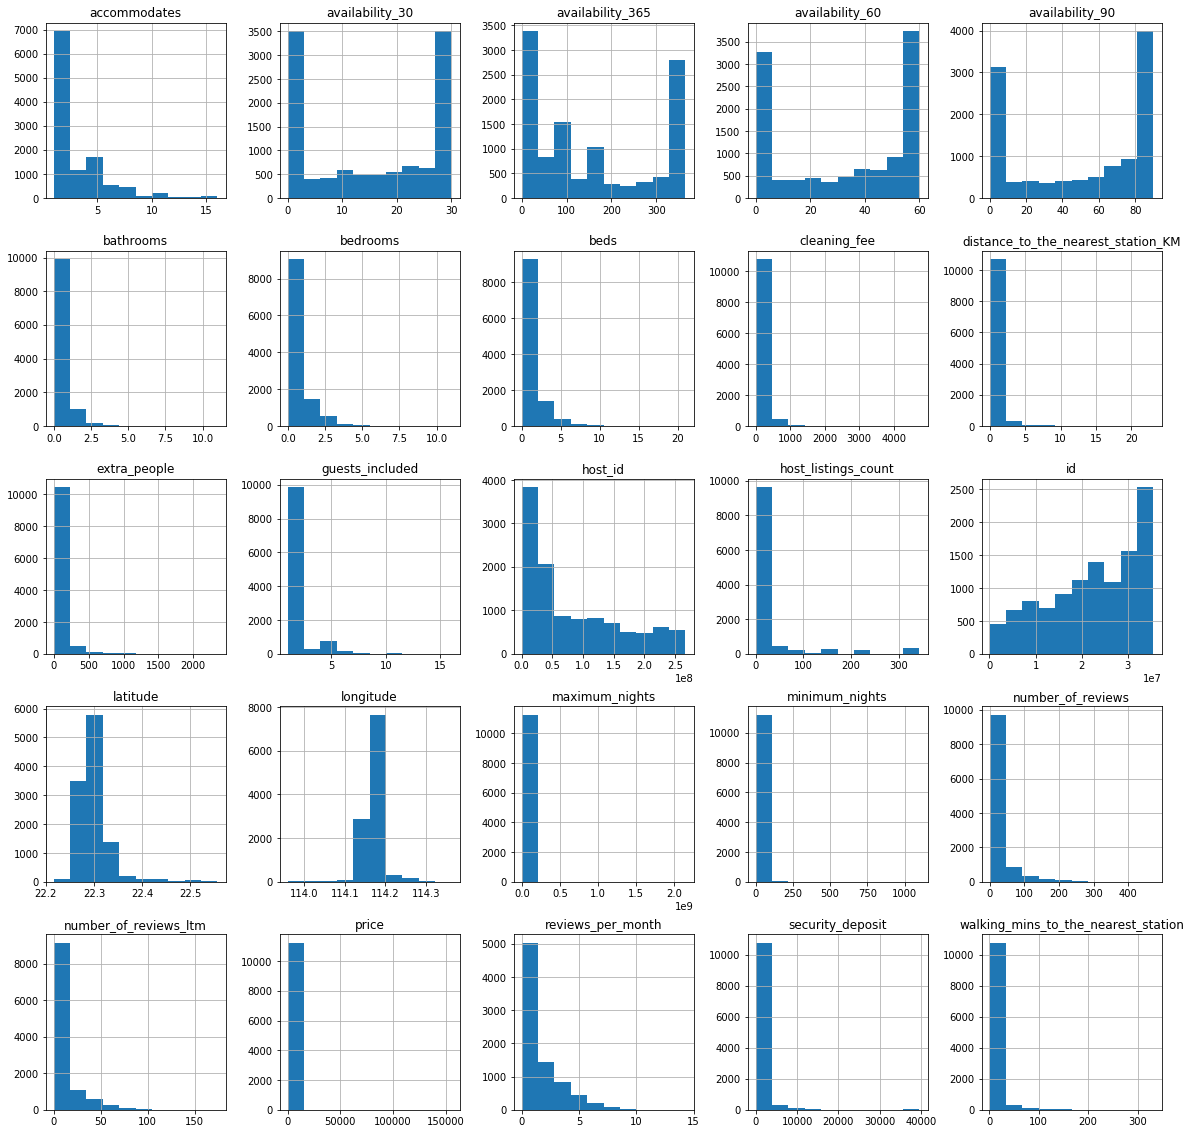

In [19]:
#Plotting histograms to check distribution of numeric and boolean variables
listings.hist(figsize=(20,20));

In [20]:
#Drop boolean columns with single category
listings.drop(['has_availability', 'host_has_profile_pic', 'is_business_travel_ready', 'require_guest_phone_verification', 'require_guest_profile_picture'], axis=1, inplace=True)

### Remove 'neighbourhood' column as it is only extension of 'neighbourhood_cleansed' column which contains sparse districts in Hong Kong

In [21]:
#listings['neighbourhood'].value_counts()
listings.drop('neighbourhood', axis=1, inplace=True)

### Remove 'number_of_reviews_ltm' and 'reviews_per_month' as they are highly correlated with number_of_reviews 

In [22]:
listings.drop(['number_of_reviews_ltm', 'reviews_per_month'], axis=1, inplace=True)

### Remove listing with advertised price equal to 0

In [23]:
print(str(len(listings[listings['price'] == 0])) +' listings with zero advertised price will be removed.')
listings = listings[listings['price'] != 0]

5 listings with zero advertised price will be removed.


### Grouping missing value into "unknown"category for 'host_response_time'

In [24]:
listings[['host_response_time']] = listings['host_response_time'].apply(lambda x: str(x).replace("nan", "unknown"))
listings['host_response_time'].value_counts(normalize=True)

within an hour        0.527528
unknown               0.211065
within a few hours    0.157876
within a day          0.086098
a few days or more    0.017433
Name: host_response_time, dtype: float64

### Binning 'host_response_rate' into four groups

In [25]:
listings['host_response_rate'] = pd.to_numeric(listings['host_response_rate'].replace(regex=["%"], value=""), errors='coerce')

#Binning into four groups
binning_labels = ['0-49%', '50-89%', '90-99%', '100%']
category = [0, 50, 90, 99, 100]
listings['host_response_rate'] = pd.cut(listings['host_response_rate'], labels = binning_labels, bins = category, include_lowest=True)

# Converting to string
listings['host_response_rate'] = listings['host_response_rate'].astype('str')

# Replace nulls with 'unknown'
listings['host_response_rate'].replace('nan', 'unknown', inplace=True)

# Category counts
listings['host_response_rate'].value_counts()

100%       5889
unknown    2373
90-99%     1406
50-89%     1226
0-49%       349
Name: host_response_rate, dtype: int64

### Create calculated field 'host_duration' to measure duration of the host lifetime on Airbnb.

In [26]:
#Drop listings without values of 'host_since' (n=7)
listings.dropna(subset=['host_since'], inplace=True)

#Convert data to correct type (datetime)
listings['last_scraped'] = pd.to_datetime(listings['last_scraped'], format='%d/%m/%Y')
listings['host_since'] = pd.to_datetime(listings['host_since'], format='%d/%m/%Y')

#Create new variable 'host listed days' to calculate the number of days between host join date and listing last seen date
listings['host_duration_days'] = (listings['last_scraped'] - listings['host_since']).dt.days

#Keep 'host_since' for EDA while dropping 'last_scraped' column as it is no longer useful
listings.drop(['last_scraped'], axis=1, inplace=True)

### Create calculated field 'price_per_person' to measure advertised price per person

In [27]:
listings['price_per_person'] = (listings['price'] / listings['accommodates']).astype('int64')

### Grouping sparse property types into three main categories: Apartment/ House/ Other

In [28]:
#listings['property_type'].value_counts()

#Regrouping categories into houses, apartments or others
listings['property_type'].replace({
    'Condominium': 'Apartment',
    'Serviced apartment': 'Apartment',
    'Aparthotel': 'Apartment',
    'Loft': 'Apartment',
    'Townhouse': 'House',
    'Bungalow': 'House',
    'Cottage': 'House',
    'Villa': 'House',
    'Tiny house': 'House',
    'Earth house': 'House',
    'Chalet': 'House'
    }, inplace=True)

#Group other categories with 'Other'
listings.loc[~listings['property_type'].isin(['House', 'Apartment']), 'property_type'] = 'Other'

### Grouping minor cancellation policies into three main categories

In [29]:
listings['cancellation_policy'].value_counts()

strict_14_with_grace_period    6354
flexible                       3152
moderate                       1692
super_strict_60                  22
super_strict_30                  14
strict                            2
Name: cancellation_policy, dtype: int64

In [30]:
# Replacing categories
listings['cancellation_policy'].replace({
    'super_strict_30': 'strict_14_with_grace_period',
    'super_strict_60': 'strict_14_with_grace_period',
    'strict': 'strict_14_with_grace_period',
    }, inplace=True)

# (3) Data cleansing for amenities

### Amenities is a list of additional features in the property. Given that some amenities are more important than others (e.g. wifi is more likely to increase price than a oven), this feature will not be useful to explain differences in prices if all amenities are included (no matter how important they are).

In [31]:
# Creating a set of all possible amenities
amenities = listings["amenities"].str.split(",",expand=True)
amenities = amenities.replace(regex=["[^\w\s]"], value="")
amenities_list = [amenities[item].unique().tolist() for item in amenities.columns.values]
amenities_list = set(list(chain.from_iterable(amenities_list)))
amenities_list.remove('')
amenities_list.remove(None)
amenities_list

{' toilet',
 '24hour checkin',
 'Accessibleheight bed',
 'Accessibleheight toilet',
 'Air conditioning',
 'Air purifier',
 'BBQ grill',
 'Baby bath',
 'Baby monitor',
 'Babysitter recommendations',
 'Bathtub',
 'Bathtub with bath chair',
 'Beach essentials',
 'Beachfront',
 'Bed linens',
 'Breakfast',
 'Building staff',
 'Buzzerwireless intercom',
 'Cable TV',
 'Carbon monoxide detector',
 'Cats',
 'Ceiling hoist',
 'Changing table',
 'Childrenâs books and toys',
 'Childrenâs dinnerware',
 'Cleaning before checkout',
 'Coffee maker',
 'Cooking basics',
 'Crib',
 'Disabled parking spot',
 'Dishes and silverware',
 'Dishwasher',
 'Dogs',
 'Doorman',
 'Dryer',
 'EV charger',
 'Electric profiling bed',
 'Elevator',
 'Essentials',
 'Ethernet connection',
 'Extra pillows and blankets',
 'Extra space around bed',
 'Extra space around shower and toilet',
 'Familykid friendly',
 'Fire extinguisher',
 'Fireplace guards',
 'Firm mattress',
 'First aid kit',
 'Fixed grab bars for shower',
 'Fixed 

In [32]:
print("Total amenities: " + str(len(amenities_list)))

Total amenities: 127


### Encode amenities as dummy variables

In [33]:
for items in amenities_list:
    listings[items] = listings["amenities"].apply(lambda x: 1 if items in x else 0)

### Remove the amenities which contains in less than 10% of listings

In [34]:
# Produces a list of amenity features where one category (true or false) contains fewer than 10% of listings
infrequent_amenities = []

for col in listings.iloc[:,48:].columns:
    if listings[col].sum() < len(listings)/10:
        infrequent_amenities.append(col)
print(infrequent_amenities)

# Dropping infrequent amenity features
listings.drop(infrequent_amenities, axis=1, inplace=True)

['Paid parking off premises', '24hour checkin', 'Free parking on premises', 'Pocket wifi', 'Gym', 'Pets allowed', 'Keypad', 'Oven', 'Hot tub', 'Wide entryway', 'Beach essentials', 'Cats', 'Game console', 'Baby monitor', 'Beachfront', 'Childrenâs books and toys', 'Private living room', 'Outlet covers', 'Free street parking', 'Other pets', 'Smoking allowed', 'Pack ân Playtravel crib', 'Safety card', 'Window guards', 'Electric profiling bed', 'Garden or backyard', 'Mobile hoist', 'Crib', 'Accessibleheight toilet', 'Wide clearance to shower', 'Hot water kettle', 'Fixed grab bars for toilet', 'Paid parking on premises', 'Ceiling hoist', 'Lake access', 'Welllit path to entrance', 'EV charger', 'No stairs or steps to enter', 'Patio or balcony', 'Kitchenette', 'Breakfast', 'Air purifier', 'Wide doorway to guest bathroom', 'Lockbox', 'Single level home', 'Indoor fireplace', 'Wide hallways', 'Cleaning before checkout', 'Pets live on this property', 'Changing table', 'Suitable for events', 'Acces

In [35]:
#count of finally selected amenities
len(amenities_list) - len(infrequent_amenities)

34

### Out of 127 amenities features, we finally keep 34 of them only.

In [36]:
#Overview of listings
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11236 entries, 0 to 11247
Data columns (total 83 columns):
id                                     11236 non-null int64
latitude                               11236 non-null float64
longitude                              11236 non-null float64
host_id                                11236 non-null int64
host_since                             11236 non-null datetime64[ns]
host_response_time                     11236 non-null object
host_response_rate                     11236 non-null object
host_is_superhost                      11236 non-null object
host_listings_count                    11236 non-null float64
host_identity_verified                 11236 non-null object
neighbourhood_cleansed                 11236 non-null object
is_location_exact                      11236 non-null object
nearest_mtr_station                    11236 non-null object
distance_to_the_nearest_station_KM     11236 non-null float64
walking_mins_to_the_nearest

## Finally, we have 11236 listings with 83 features (in which 34 of them are amenity features).

# (4) Data cleansing for 'calendar.csv'

The goal of this part is to clean the calendar dataset so as to run price seasonality analysis.

In [37]:
calendar_df = pd.read_csv("calendar.csv.gz")

In [38]:
print('We have', calendar_df.date.nunique(), 'days and', calendar_df.listing_id.nunique(), 'unique listings in the calendar data.')

We have 365 days and 12107 unique listings in the calendar data.


In [39]:
listings_id = list(listings['id'])
calendar_list = list(dict.fromkeys(calendar_df['listing_id']))
drop_listings = []

#List of listings not found in final listing list
for list_c in calendar_list:
    if list_c not in listings_id:
        drop_listings.append(list_c)

In [40]:
calendar_df = calendar_df[~calendar_df['listing_id'].isin(drop_listings)]

print('After removing', len(drop_listings), 'listings not exist in the cleansed "listing" dataframe, now we have', calendar_df.date.nunique(), 'days and', calendar_df.listing_id.nunique(), 'unique listings in the calendar data.')

After removing 871 listings not exist in the cleansed "listing" dataframe, now we have 365 days and 11236 unique listings in the calendar data.


In [41]:
#Remove special characters ('$',',') and then convert price column to float
calendar_df.price = calendar_df.price.str.lstrip('$').str.replace(',', '')
calendar_df.price = calendar_df.price.astype('float')

#Convert string date to datetime object
calendar_df.date = pd.to_datetime(calendar_df.date)

In [42]:
#Overview of calendar
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4101140 entries, 0 to 4414310
Data columns (total 7 columns):
listing_id        int64
date              datetime64[ns]
available         object
price             float64
adjusted_price    object
minimum_nights    int64
maximum_nights    int64
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 250.3+ MB


In [43]:
#Export cleansed listings datasets
calendar_df.to_csv('calendar(cleansed)' + '.csv.gz', index = False, compression='gzip')

# (5) Exploring Venues per Neighborhood (District) in Hong Kong

In [44]:
#required module for neighbourhood analysis
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import requests
import descartes

### We will use Foursquare API to explore Top 10 popular places around each neighbourhood.
### The query parameters include but not limited to:
- CLIENT_ID - API credential
- CLIENT_SECRET - API credential
- Versioning (V) - date in YYYYMMDD format that lets you tell Foursquare “I’m prepared for API changes up to this date.”
- Latitude & Longitude (ll) - Latitude and longitude of the user’s location
- radius - Radius to search within, in meters
- limit - Number of results to return
- sortByPopularity - Boolean flag to sort the results by popularity instead of relevance
#### Reference: https://developer.foursquare.com/docs/api/venues/explore

In [45]:
#Define Foursquare Credentials for using Places API
CLIENT_ID = 'YOUR_CLIENT_ID'
CLIENT_SECRET = 'YOUR_CLIENT_SECRET'

version = '20190610'
radius = 1000
limit = 10
sortByPopularity = 1

Although GeoJSON file of neighbourhoods (18 districts) of the city is available on InsideAirbnb, some coordinates derived from the centroid of district boundaries are hard for us to find 'meaningful' proximity venues near the district. In view of avoiding proximity venue misinterpretation, I scratched the coordinates for each districts on latitude.to and save it in 'hk_districts_coordinates.csv' for the following neighbourhood analysis.

In [46]:
#Importing coordinates of 18 districts in hk 
map_df = pd.read_csv('hk_districts_coordinates.csv')
map_df.head()

,district,latitude,longitude
0,Central & Western,22.2833,114.1500
1,Yau Tsim Mong,22.3116,114.1707
2,Yuen Long,22.4446,114.0222
3,Wan Chai,22.2763,114.1826
4,Southern,22.2432,114.1974


In [47]:
# Function to loop for venues through all neighbourhoods
def exploreNearbyVenues(names, latitudes, longitudes):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&sortByPopularity={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET,
            version,
            lat, 
            lng, 
            radius,
            limit,
            sortByPopularity)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                             'Neighbourhood Latitude', 
                             'Neighbourhood Longitude', 
                             'Venue', 
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Venue Category']
    
    return(nearby_venues)

Run the above function to call Foursquare API.

In [48]:
district_venues = exploreNearbyVenues(names=map_df['district'],
                                      latitudes=map_df['latitude'],
                                      longitudes=map_df['longitude']
                                      )

print('The result returns {} venues with {} unique categories for {} districts.'.format(len(district_venues['Venue'].unique()),
                                                                                        len(district_venues['Venue Category'].unique()),
                                                                                        len(district_venues['Neighbourhood'].unique())))

district_venues.head()

The result returns 153 venues with 60 unique categories for 18 districts.


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Central & Western,22.2833,114.15,ifc mall (國際金融中心商場),22.284613,114.158156,Shopping Mall
1,Central & Western,22.2833,114.15,Tai Kwun Centre for Heritage and Arts (大館古蹟及藝術館),22.281224,114.154032,Art Museum
2,Central & Western,22.2833,114.15,Apple ifc mall,22.284602,114.159072,Electronics Store
3,Central & Western,22.2833,114.15,city'super,22.286319,114.157806,Supermarket
4,Central & Western,22.2833,114.15,Pure Fitness,22.285137,114.159455,Gym / Fitness Center


In [49]:
#Count venue collected for each neighbourhood:
district_venues[['Neighbourhood','Venue']].groupby('Neighbourhood').count().sort_values(['Venue'], ascending=True)

,Venue
Neighbourhood,
Islands,2
North,3
Central & Western,10
Wong Tai Sin,10
Wan Chai,10
Tuen Mun,10
Tsuen Wan,10
Tai Po,10
Southern,10


Even though the Place API search quota is set up to 10 places within 1KM of pre-defined coordinates, the API only returns 2 venues for Islands and North Districts respectively.

From guests perspective, it is believed that level of proximity to 'hotel' does not matter when thinking about the convenience of location. We can therefore remove "Hotel" from the the venue list. 

In [50]:
district_venues.drop(district_venues.loc[district_venues['Venue Category']=='Hotel'].index, inplace=True)
district_venues.reset_index(drop=True)

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Central & Western,22.28330,114.15000,ifc mall (國際金融中心商場),22.284613,114.158156,Shopping Mall
1,Central & Western,22.28330,114.15000,Tai Kwun Centre for Heritage and Arts (大館古蹟及藝術館),22.281224,114.154032,Art Museum
2,Central & Western,22.28330,114.15000,Apple ifc mall,22.284602,114.159072,Electronics Store
3,Central & Western,22.28330,114.15000,city'super,22.286319,114.157806,Supermarket
4,Central & Western,22.28330,114.15000,Pure Fitness,22.285137,114.159455,Gym / Fitness Center
...,...,...,...,...,...,...,...
152,Kwun Tong,22.31570,114.23310,KFC (肯德基),22.312584,114.225568,Fast Food Restaurant
153,Kwun Tong,22.31570,114.23310,Phở Lê (錦麗),22.312790,114.225225,Vietnamese Restaurant
154,Kwun Tong,22.31570,114.23310,Genki Sushi (元気寿司),22.312102,114.225154,Sushi Restaurant
155,Islands,22.26279,113.96554,Lantau Mountain Camp (爛頭營),22.258358,113.960033,Mountain


In [51]:
#district_venues['Venue Category'].value_counts()

Besides, there are dozens of sub-categories of restuarant (e.g. bar, buffet, Fast Food Restaurant) in return. It is better to group them all into one single category named "Restaurant"

In [52]:
restaurant_subgroup = list(district_venues.loc[district_venues['Venue Category'].str.contains('Restaurant', case=False), 'Venue Category'].unique())
restaurant_subgroup += ['Cha Chaan Teng','Fried Chicken Joint','Burger Joint','Pizza Place', 'Bar', 'Noodle House']

In [53]:
#Group all resturant-related subcategories together under "Restaurant"
district_venues['Venue Category'].replace(to_replace = restaurant_subgroup,
                                          value = 'Restaurant', 
                                          inplace = True)

For easy understanding, let's rename 'Multiplex' as 'Movie Theater' as well.

In [54]:
district_venues['Venue Category'].replace('Multiplex', 'Movie Theater', inplace = True)

Lastly, concatenate Venue Latitude and Longitude into one string for the convenience of using Google Map API

In [55]:
district_venues['Venue LatLng'] = round(district_venues['Venue Latitude'],6).astype(str) + ',' + round(district_venues['Venue Longitude'],6).astype(str)

In [56]:
#Export dataframe district_venues to csv
district_venues.to_csv('district_popular_venues' + '.csv', index = False, encoding = 'utf-8-sig')

## What is the categories for the top 3 most popular venue?

First, rank the popularity of venue category by district:

In [57]:
sorted_district_venues = district_venues.groupby('Neighbourhood')['Venue Category'].apply(lambda district_venues: district_venues.reset_index(drop=True)).unstack();

In [58]:
def rename_column(df, selected_columns):

    #rename column to make it easy to understand (e.g. '1st most popular venue', '2nd most popular venue'...)
    re_col = []

    for i in selected_columns:
        if i == 0:
            re_col.append(str(i+1) + 'st most popular venue')
        
        elif i == 1:
            re_col.append(str(i+1) + 'nd most popular venue')
    
        elif i == 2:
            re_col.append(str(i+1) + 'rd most popular venue')
        
        else:
            re_col.append(str(i+1) + 'th most popular venue')
        
    df.columns = [re_col]
    df.reset_index(inplace=True)

rename_column(sorted_district_venues, sorted_district_venues.columns.values)

In [59]:
#Do the same for sorted venue coordinate group by neighbourhood
popular_venues_coordinates = district_venues.groupby('Neighbourhood')['Venue LatLng'].apply(lambda district_venues: district_venues.reset_index(drop=True)).unstack()

#run the function to rename columns in 'popular_venues_coordinates'
rename_column(popular_venues_coordinates, popular_venues_coordinates.columns.values)

In [60]:
#For analysis in next topic -- Measurement of walkability for each listing
sorted_district_venues.to_csv('sorted_district_venues' + '.csv', index = False, encoding = 'utf-8-sig')
popular_venues_coordinates.to_csv('sorted_district_venues_coordinate' + '.csv', index = False, encoding = 'utf-8-sig')

sorted_district_venues = pd.read_csv('sorted_district_venues.csv')
sorted_district_venues

,Neighbourhood,1st most popular venue,2nd most popular venue,3rd most popular venue,4th most popular venue,5th most popular venue,6th most popular venue,7th most popular venue,8th most popular venue,9th most popular venue,10th most popular venue
0,Central & Western,Shopping Mall,Art Museum,Electronics Store,Supermarket,Gym / Fitness Center,Coffee Shop,Movie Theater,Sandwich Place,NaN,NaN
1,Eastern,Metro Station,Farmers Market,Coffee Shop,Restaurant,Cafeteria,Sporting Goods Shop,Dessert Shop,Snack Place,Restaurant,Restaurant
2,Islands,Mountain,Scenic Lookout,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Kowloon City,Shopping Mall,Park,Market,Restaurant,Restaurant,Coffee Shop,Café,Restaurant,Restaurant,NaN
4,Kwai Tsing,Metro Station,Shopping Mall,Restaurant,Theater,Platform,Restaurant,Movie Theater,Dance Studio,Restaurant,Restaurant
5,Kwun Tong,Shopping Mall,Metro Station,Building,Restaurant,Electronics Store,Restaurant,Supermarket,Restaurant,Restaurant,Restaurant
6,North,Shopping Mall,Restaurant,Restaurant,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Sai Kung,Pier,Park,Bus Station,Restaurant,Restaurant,Dessert Shop,Restaurant,Restaurant,Restaurant,Stadium
8,Sha Tin,Shopping Mall,Train Station,Train Station,Bus Station,Restaurant,River,Restaurant,Restaurant,Restaurant,NaN
9,Sham Shui Po,Metro Station,Shopping Mall,Shopping Mall,Department Store,Restaurant,Park,Coffee Shop,Bus Station,Restaurant,Athletics & Sports


In [61]:
print('The Top 3 most popular venue category across HK districts are {},{} and {}.'.format(sorted_district_venues['1st most popular venue'].mode().iloc[0],
                                                                                           sorted_district_venues['2nd most popular venue'].mode().iloc[0],
                                                                                           sorted_district_venues['3rd most popular venue'].mode().iloc[0]))

The Top 3 most popular venue category across HK districts are Shopping Mall,Shopping Mall and Shopping Mall.


### No wonder Hong Kong is charactacterised as a shopping paradise for many tourists. As you can see, the result shows that the top 3 most popular venues among districts are both 'Shopping Mall'.  Apart from shopping, it makes sense to see people are more likely to look for other venues in some other places such as beach and pier in Southern and Sai Kung District respectively.

# (6) Measurement of walkability score per listing within the neighbourhood

Criteria:
- Proximity of railway (the Nearest MTR station)
- Accessibility of the top 5 most popular venues (Point-of-interest, aka 'POI') in the neighbourbood (POI was retrieved from Foursquare API)

In [62]:
listings.head()

,id,latitude,longitude,host_id,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood_cleansed,is_location_exact,nearest_mtr_station,distance_to_the_nearest_station_KM,walking_mins_to_the_nearest_station,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,instant_bookable,number_of_reviews,first_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,time_since_first_review,time_since_last_review,host_duration_days,price_per_person,Doorman,Laptop friendly workspace,Air conditioning,Host greets you,Microwave,Smoke detector,Hangers,Stove,Fire extinguisher,Iron,Luggage dropoff allowed,Cooking basics,First aid kit,Washer,Essentials,Lock on bedroom door,Long term stays allowed,Extra pillows and blankets,Hot water,Refrigerator,Elevator,Kitchen,Private entrance,Wifi,Heating,Cable TV,Carbon monoxide detector,Dishes and silverware,Shampoo,Dryer,Internet,TV,Bed linens,Hair dryer
0,69074,22.28352,114.15018,160139,2010-07-07,within an hour,100%,1,2.0,1,Central & Western,1,Sheung Wan Station,0.5,7,Apartment,Entire home/apt,3,1.0,1.0,2.0,Real Bed,"{""Cable TV"",Internet,Wifi,""Air conditioning"",K...",1412.0,2353.0,314.0,2,157.0,3,365,7,13,43,133,0,130,2011-02-14,95-100,10,9,10,10,10,9,strict_14_with_grace_period,4+ years,6-12 months,3260,470,0,1,1,0,0,1,1,0,0,1,0,0,1,1,1,0,1,0,1,0,0,1,0,1,1,1,1,0,1,1,1,1,0,1
1,103760,22.28407,114.15570,304876,2010-11-30,within a few hours,90-99%,0,12.0,0,Central & Western,1,Central Station,0.4,4,Apartment,Entire home/apt,6,1.0,2.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",855.0,784.0,306.0,2,196.0,2,365,21,43,73,332,0,257,2011-06-19,80-94,9,9,10,10,10,9,strict_14_with_grace_period,4+ years,6-12 months,3114,142,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,1,1,0,0,1,0,1,1,0,0
2,132773,22.28868,114.14494,304876,2010-11-30,within a few hours,90-99%,0,12.0,0,Central & Western,0,Sai Ying Pun Station,0.1,2,Apartment,Entire home/apt,6,1.0,2.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",1059.0,784.0,306.0,3,227.0,2,365,23,40,52,301,0,255,2011-07-19,80-94,9,9,9,9,9,9,strict_14_with_grace_period,4+ years,2-6 months,3114,176,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,1,1,1,0,0,1,0,1,1,0,0
3,133390,22.28343,114.15539,654642,2011-06-02,within a day,100%,0,1.0,1,Central & Western,1,Central Station,0.4,4,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",941.0,1176.0,0.0,1,0.0,2,60,0,1,1,58,0,27,2011-04-07,95-100,10,9,10,10,10,10,moderate,4+ years,1+ year,2930,470,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,1,1,0,1,0,1,1,0,0
4,163214,22.28494,114.15251,767910,2011-07-01,unknown,unknown,0,0.0,1,Central & Western,1,Sheung Wan Station,0.2,3,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",1051.0,1000.0,160.0,1,0.0,5,30,23,53,83,83,0,0,NaT,no reviews,no reviews,no reviews,no reviews,no reviews,no reviews,no reviews,moderate,no reviews,no reviews,2901,525,0,0,1,1,0,0,1,1,0,1,0,1,0,0,1,0,0,0,1,1,0,1,0,1,1,1,0,1,1,0,1,1,0,1


In [63]:
#Create new df and extract listing id and neighbourhood from listing df only
listing_neighbourhood = listings[['id','latitude', 'longitude', 'neighbourhood_cleansed']]

In [64]:
#Concatenate Latitude and Longitude into one single variable
listing_neighbourhood['origin_coordinate'] = round(listings['latitude'],5).astype(str) + ',' + round(listings['longitude'],5).astype(str)
listing_neighbourhood.drop(['latitude','longitude'], axis=1, inplace=True)
listing_neighbourhood.rename(columns={'neighbourhood_cleansed':'Neighbourhood'}, inplace=True)
listing_neighbourhood.head()

,id,Neighbourhood,origin_coordinate
0,69074,Central & Western,"22.28352,114.15018"
1,103760,Central & Western,"22.28407,114.1557"
2,132773,Central & Western,"22.28868,114.14494"
3,133390,Central & Western,"22.28343,114.15539"
4,163214,Central & Western,"22.28494,114.15251"


In [65]:
#select the top 5 most popular venue per neighbourhood
sorted_district_venues_coordinate = pd.read_csv('sorted_district_venues_coordinate.csv')
sorted_district_venues_coordinate = sorted_district_venues_coordinate.iloc[:, list(range(6))]

In [66]:
#Using 'Neighbourhood' as key, map the top 5 most popular venue to listing id 
listing_neighbourhood = pd.merge(listing_neighbourhood, sorted_district_venues_coordinate, on='Neighbourhood')
listing_neighbourhood.head()

,id,Neighbourhood,origin_coordinate,1st most popular venue,2nd most popular venue,3rd most popular venue,4th most popular venue,5th most popular venue
0,69074,Central & Western,"22.28352,114.15018","22.284613,114.158156","22.281224,114.154032","22.284602,114.159072","22.286319,114.157806","22.285137,114.159455"
1,103760,Central & Western,"22.28407,114.1557","22.284613,114.158156","22.281224,114.154032","22.284602,114.159072","22.286319,114.157806","22.285137,114.159455"
2,132773,Central & Western,"22.28868,114.14494","22.284613,114.158156","22.281224,114.154032","22.284602,114.159072","22.286319,114.157806","22.285137,114.159455"
3,133390,Central & Western,"22.28343,114.15539","22.284613,114.158156","22.281224,114.154032","22.284602,114.159072","22.286319,114.157806","22.285137,114.159455"
4,163214,Central & Western,"22.28494,114.15251","22.284613,114.158156","22.281224,114.154032","22.284602,114.159072","22.286319,114.157806","22.285137,114.159455"


In [67]:
#Create dataframe to capture listing id, origin coordinate and venue coordinate for each row
df_merged = pd.DataFrame(columns=['id', 'neighbourhood', 'origin_coordinate', 'venue_coordinate', 'remarks'])

for i in range(3,8): 
    temp = pd.DataFrame({'id': list(listing_neighbourhood['id']),
                         'neighbourhood': list(listing_neighbourhood['Neighbourhood']),
                         'origin_coordinate': list(listing_neighbourhood['origin_coordinate']),
                         'venue_coordinate': list(listing_neighbourhood[listing_neighbourhood.columns[i]]),
                         'remarks': listing_neighbourhood.columns[i]
                        })
    
    df_merged = pd.concat([df_merged, temp])
    
df_merged

,id,neighbourhood,origin_coordinate,venue_coordinate,remarks
0,69074,Central & Western,"22.28352,114.15018","22.284613,114.158156",1st most popular venue
1,103760,Central & Western,"22.28407,114.1557","22.284613,114.158156",1st most popular venue
2,132773,Central & Western,"22.28868,114.14494","22.284613,114.158156",1st most popular venue
3,133390,Central & Western,"22.28343,114.15539","22.284613,114.158156",1st most popular venue
4,163214,Central & Western,"22.28494,114.15251","22.284613,114.158156",1st most popular venue
...,...,...,...,...,...
11231,34296432,Kwun Tong,"22.30767,114.21679","22.312401,114.225336",5th most popular venue
11232,34296991,Kwun Tong,"22.30927,114.22042","22.312401,114.225336",5th most popular venue
11233,34487935,Kwun Tong,"22.30928,114.22049","22.312401,114.225336",5th most popular venue
11234,34613665,Kwun Tong,"22.31776,114.23415","22.312401,114.225336",5th most popular venue


In [68]:
df_merged.to_csv('listing_proximity_venues_coordinates' + '.csv', index = False, encoding = 'utf-8-sig')

### After getting walking distance and time for each pair of origins and destinations using Google Map Distance Matrix API, the next step is to calculate walking score for each listing.

In [69]:
listing_proximity_venues_coordinates_final = pd.read_csv('listing_proximity_venues_coordinates(combined).csv')
listing_proximity_venues_coordinates_final.head()

,ListingID,Neighbourhood,Origin,Destination,remarks,Distance,Walking time (mins)
0,69074,Central & Western,"22.28352,114.15018","22.284613,114.158156",1st most popular venue,1.5 km,20.0
1,103760,Central & Western,"22.28407,114.1557","22.284613,114.158156",1st most popular venue,0.8 km,11.0
2,132773,Central & Western,"22.28868,114.14494","22.284613,114.158156",1st most popular venue,1.9 km,26.0
3,133390,Central & Western,"22.28343,114.15539","22.284613,114.158156",1st most popular venue,0.8 km,11.0
4,163214,Central & Western,"22.28494,114.15251","22.284613,114.158156",1st most popular venue,1.2 km,16.0


In [70]:
#Calculate average walking time to proximity venue group by listing id
listing_avg_walking_time = listing_proximity_venues_coordinates_final.groupby('ListingID')['Walking time (mins)'].mean().to_frame()
listing_avg_walking_time.reset_index(inplace=True)

In [71]:
#Drop (20) listings without values of ''Walking time (mins)'...most likely those were located near boundary areas or unaccessible to proximity venues by walking
listing_avg_walking_time.dropna(subset=['Walking time (mins)'], inplace=True)

In [72]:
#Retain unique 'ListingID' with 'Neighbourhood' fields only in 'listing_proximity_venues_coordinates_final'
listing_proximity_venues_coordinates_final = listing_proximity_venues_coordinates_final[['ListingID','Neighbourhood']].drop_duplicates('ListingID')
listing_proximity_venues_coordinates_final

,ListingID,Neighbourhood
0,69074,Central & Western
1,103760,Central & Western
2,132773,Central & Western
3,133390,Central & Western
4,163214,Central & Western
...,...,...
11231,34296432,Kwun Tong
11232,34296991,Kwun Tong
11233,34487935,Kwun Tong
11234,34613665,Kwun Tong


In [73]:
#Normalize listing venue walkability (range is set between 0-100)
listing_venues_walkability = listing_proximity_venues_coordinates_final.merge(listing_avg_walking_time, on='ListingID', how = 'inner')

scaler = MinMaxScaler(feature_range=(0, 100))  #Create the Scaler object
listing_venues_walkability['normalized_walkability_score'] = scaler.fit_transform(listing_venues_walkability['Walking time (mins)'].values.reshape(-1,1))

listing_venues_walkability.rename(columns = {'ListingID':'id', 'Walking time (mins)':'avg_walking_mins_to_top5_neighhourhood_venues'}, inplace = True)

In [74]:
listing_venues_walkability = listing_venues_walkability[['id', 'avg_walking_mins_to_top5_neighhourhood_venues', 'normalized_walkability_score']]
listings_final = listings.merge(listing_venues_walkability, on='id', how = 'inner')
listings_final

,id,latitude,longitude,host_id,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood_cleansed,is_location_exact,nearest_mtr_station,distance_to_the_nearest_station_KM,walking_mins_to_the_nearest_station,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,instant_bookable,number_of_reviews,first_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,time_since_first_review,time_since_last_review,host_duration_days,price_per_person,Doorman,Laptop friendly workspace,Air conditioning,Host greets you,Microwave,Smoke detector,Hangers,Stove,Fire extinguisher,Iron,Luggage dropoff allowed,Cooking basics,First aid kit,Washer,Essentials,Lock on bedroom door,Long term stays allowed,Extra pillows and blankets,Hot water,Refrigerator,Elevator,Kitchen,Private entrance,Wifi,Heating,Cable TV,Carbon monoxide detector,Dishes and silverware,Shampoo,Dryer,Internet,TV,Bed linens,Hair dryer,avg_walking_mins_to_top5_neighhourhood_venues,normalized_walkability_score
0,69074,22.28352,114.15018,160139,2010-07-07,within an hour,100%,1,2.0,1,Central & Western,1,Sheung Wan Station,0.500,7,Apartment,Entire home/apt,3,1.0,1.0,2.0,Real Bed,"{""Cable TV"",Internet,Wifi,""Air conditioning"",K...",1412.0,2353.0,314.0,2,157.0,3,365,7,13,43,133,0,130,2011-02-14,95-100,10,9,10,10,10,9,strict_14_with_grace_period,4+ years,6-12 months,3260,470,0,1,1,0,0,1,1,0,0,1,0,0,1,1,1,0,1,0,1,0,0,1,0,1,1,1,1,0,1,1,1,1,0,1,17.6,2.977867
1,103760,22.28407,114.15570,304876,2010-11-30,within a few hours,90-99%,0,12.0,0,Central & Western,1,Central Station,0.400,4,Apartment,Entire home/apt,6,1.0,2.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",855.0,784.0,306.0,2,196.0,2,365,21,43,73,332,0,257,2011-06-19,80-94,9,9,10,10,10,9,strict_14_with_grace_period,4+ years,6-12 months,3114,142,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,1,1,0,0,1,0,1,1,0,0,11.2,1.690141
2,132773,22.28868,114.14494,304876,2010-11-30,within a few hours,90-99%,0,12.0,0,Central & Western,0,Sai Ying Pun Station,0.100,2,Apartment,Entire home/apt,6,1.0,2.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",1059.0,784.0,306.0,3,227.0,2,365,23,40,52,301,0,255,2011-07-19,80-94,9,9,9,9,9,9,strict_14_with_grace_period,4+ years,2-6 months,3114,176,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,1,1,1,0,0,1,0,1,1,0,0,23.6,4.185111
3,133390,22.28343,114.15539,654642,2011-06-02,within a day,100%,0,1.0,1,Central & Western,1,Central Station,0.400,4,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",941.0,1176.0,0.0,1,0.0,2,60,0,1,1,58,0,27,2011-04-07,95-100,10,9,10,10,10,10,moderate,4+ years,1+ year,2930,470,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,1,1,0,1,0,1,1,0,0,10.8,1.609658
4,163214,22.28494,114.15251,767910,2011-07-01,unknown,unknown,0,0.0,1,Central & Western,1,Sheung Wan Station,0.200,3,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",1051.0,1000.0,160.0,1,0.0,5,30,23,53,83,83,0,0,NaT,no reviews,no reviews,no reviews,no reviews,no reviews,no reviews,no reviews,moderate,no reviews,no reviews,2901,525,0,0,1,1,0,0,1,1,0,1,0,1,0,0,1,0,0,0,1,1,0,1,0,1,1,1,0,1,1,0,1,1,0,1,14.4,2.334004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11211,35533995,22.28577,114.13647,267338654,2019-06-09,unknown,unk

In [75]:
#Export cleansed listings datasets
#listings_final.to_csv('listings(cleansed)' + '.csv', index = False)

# (7) Exploratory Data Analysis (EDA)

In [76]:
print("For Airbnb hosts that were still listing on Airbnb as of 2019-06-10, the first host had joined since {}, and the most recent one since {}.".format(min(listings_final.host_since).strftime('%Y-%m-%d'),max(listings_final.host_since).strftime('%Y-%m-%d')))

For Airbnb hosts that were still listing on Airbnb as of 2019-06-10, the first host had joined since 2009-10-07, and the most recent one since 2019-06-09.


### Folium is a Python Library that can allow us to visualize spatial data on a map in an interactive manner. To visualize amount of Airbnb listing from districts within Hong Kong area, its class function HeatMap() is used to overlay a heat map over the map object.

In [77]:
import folium
import json
from folium.plugins import HeatMap

In [78]:
#Load a GeoJSON file representing geospatial data of HK Districts (neighbourhood)

nbh_geo_json_data = json.load(open('neighbourhoods.geojson'))

In [79]:
#count number of listing per neighbourhood

listings_final.rename(columns={'neighbourhood_cleansed':'neighbourhood'}, inplace=True)

nbh_listing_count = listings_final.groupby('neighbourhood')['id'].nunique().to_frame().reset_index()
nbh_listing_count.rename(columns ={'id':'listing_count'}, inplace=True)
nbh_listing_count.loc['17'] = ['Islands', 0]
nbh_listing_count.sort_values(by=['listing_count'],ascending=False, inplace=True)

map_df.rename(columns={'district':'neighbourhood'}, inplace=True)
nbh_listing_count = nbh_listing_count.merge(map_df, on='neighbourhood', how = 'inner')
nbh_listing_count.head()

,neighbourhood,listing_count,latitude,longitude
0,Yau Tsim Mong,4593,22.3116,114.1707
1,Central & Western,2586,22.2833,114.1500
2,Wan Chai,2124,22.2763,114.1826
3,Kowloon City,411,22.3232,114.1856
4,Eastern,403,22.2734,114.2361


Remarks: previously we have removed listings located in Islands District to avoid skewness of accessibility (walkability) measurement.

### Creating a Heat Map visualization of Airbnb listings distribution by neighbourhood

In [80]:
#prepare data for heatmap
nbh_lat = np.array(nbh_listing_count["latitude"])
nbh_lng = np.array(nbh_listing_count["longitude"])
listing_count = np.array(nbh_listing_count["listing_count"],dtype=float)
heatmap_data = [[nbh_lat[i],nbh_lng[i],listing_count[i]] for i in range(len(nbh_listing_count))]

In [81]:
m = folium.Map([22.28552, 114.15769], zoom_start=10.5)

#provide a function of the form lambda feature: {} that sets the style of each feature.
folium.GeoJson(
    nbh_geo_json_data,
    style_function=lambda feature: {'color': 'brown',
                                    'weight': 1.5,
                                    'dashArray': '5, 5',
                                    'fillOpacity': 0.1,
                                    }
).add_to(m)

#Add heatmap layer on the map
HeatMap(heatmap_data, min_opacity=0.1, blur=30).add_to(m)

m

From the above heatmap result, we can see that the listings are highly concentrated in Kowloon and Hong Kong Island Districts. Let's further plot a bar chart to show distribution of listings by district in details.

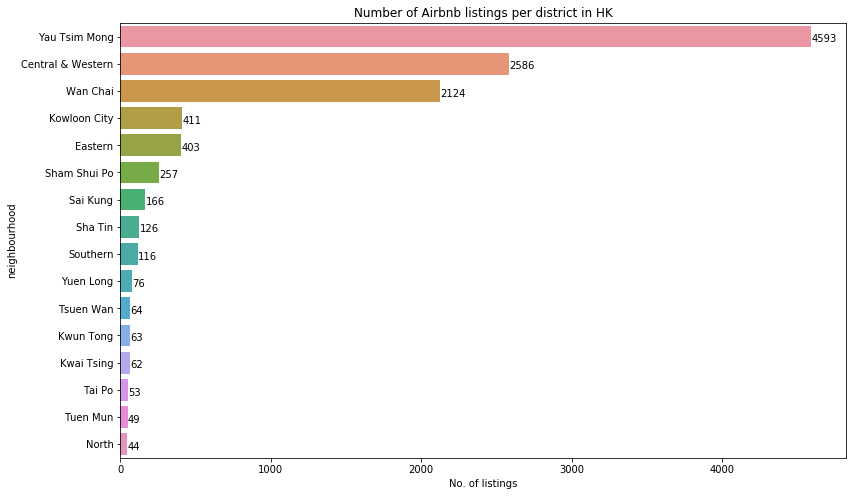

In [82]:
nbh_listing_count.sort_values("listing_count", ascending=False, inplace=True)
nbh_listing_count = nbh_listing_count[:16]

f, ax = plt.subplots(figsize=(13, 8))

sns.barplot(data=nbh_listing_count, x = 'listing_count', y = 'neighbourhood')

ax.set_title("Number of Airbnb listings per district in HK")
ax.set_xlabel('No. of listings')

for p in ax.patches:
    width = p.get_width()
    ax.text(width,
            p.get_y()+p.get_height()/2 + 0.2,
            '{:1.0f}'.format(width),
            ha="left")

Out of 11216 Airbnb listings, it is clear to see that most of them were located in Yau Tsim Wong District (4593), Central & Western District (2586) and Wan Chai District (2124), followed by Kowloon City District (411) and Eastern District (403). Although below map was captured from InsideAirbnb website on 20-Dec 2019, we can see the same result too.

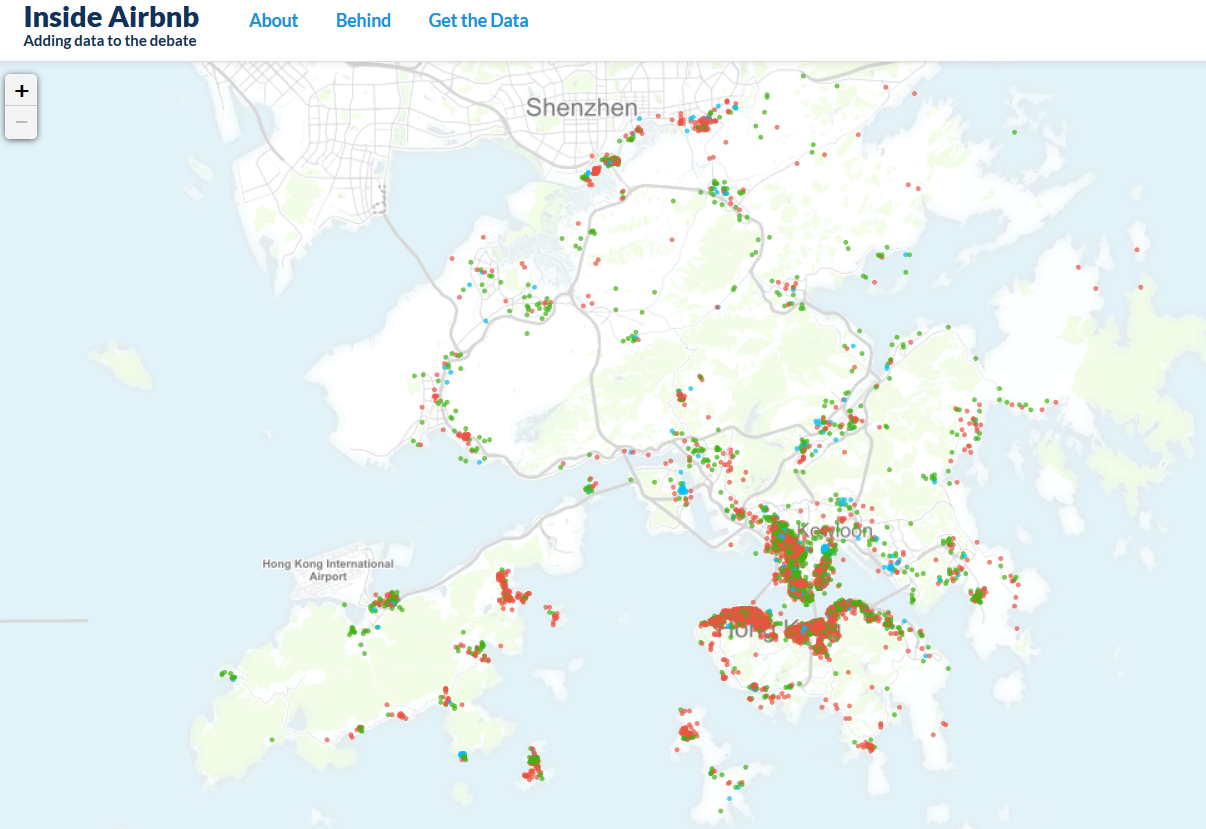

In [83]:
from IPython.display import Image
Image(filename ="snapshot from InsideAirbnb (191220).PNG", width=600, height=600)

### General description of nightly advertised price

Bear in mind that the variable 'price' refers the nightly advertised price rather than the actual amount which have been paid by previous guests. The advertised prices only reflect the arbitrary amount set by the host.

A more accurate version of price per night should be collected from companies like AirDNA that sell higher quality Airbnb data.

In [84]:
print('Nightly advertised prices range from HK${} to HK${}.'.format(int(min(listings_final['price'])), int(max(listings_final['price']))))
print('Median price per night: HK${}'.format(int(statistics.median(listings_final['price']))))
print('Average rental per night: HK${}'.format(int(statistics.mean(listings_final['price']))))

Nightly advertised prices range from HK$47 to HK$155517.
Median price per night: HK$533
Average rental per night: HK$855


### Plotting Histogram of nightly advertised price

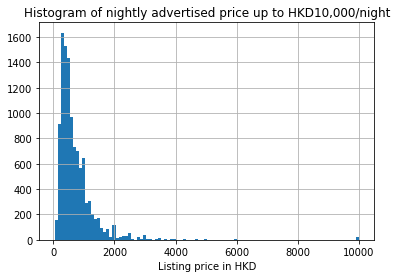

In [85]:
#Remove outliers (n=59) with price over $10000/night
listings_final.loc[(listings_final.price < 10000)].price.hist(bins=100)
plt.xlabel('Listing price in HKD')
plt.title('Histogram of nightly advertised price up to HKD10,000/night');

After removing 59 outliers with price over HK\\$10,000 per night, we can see that most listing prices were below HK\\$2,000 per night. (p.s. the most expensive rental price per night is HK\\$155,517, unbelievable)

### Listing price vs. Number of beds

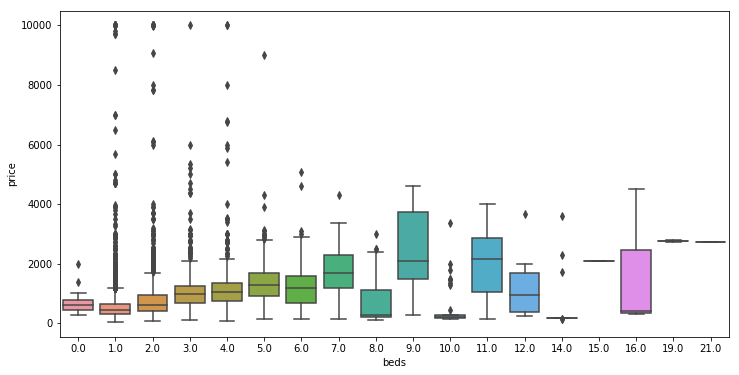

In [86]:
plt.figure(figsize=(12,6))

sns.boxplot(y='price', x='beds', data = listings_final.loc[(listings_final['price'] <= 10000)])
plt.show();

It is interesting to see that the some listings do not provide any beds, but the median price was even higher than listing with 1-bed.

### Exploring Room Type

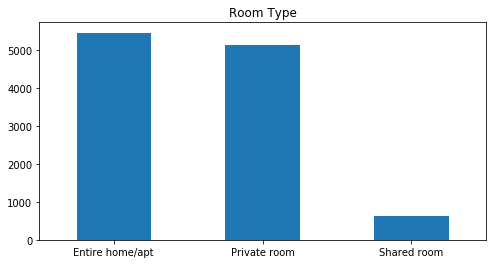

Entire home/apt    0.486626
Private room       0.457561
Shared room        0.055813
Name: room_type, dtype: float64


In [87]:
plt.figure(figsize=(8,4))
listings_final['room_type'].value_counts().plot(kind='bar')
plt.title('Room Type')
plt.xticks(rotation=0)
plt.show()

print(listings_final['room_type'].value_counts(normalize=True))

About half of listings were 'Entire homes/apartment', whereas 46% were 'Private rooms' (e.g. renting a bedroom with a bathroom only in the property). Less than 6% were 'Shared rooms' (e.g. sharing a room with other guests).

### Exploring Review Scores

In [88]:
def review_count_plot(col, figsize=(8,5)):
    """
    Use seaborn library to plot a simple bar chart of the total count for each category in the column specified.
    A figure size can optionally be specified.
    """ 
    sns.set(style="darkgrid")

    result = listings_final[col].value_counts().sort_index(ascending=True)
    
    ax = sns.countplot(x=col, data=listings_final, order=result.index)

    plt.title(col, fontsize=13)
    plt.xlabel('score')
    plt.ylabel('')

    total = len(listings_final[col])

    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 50,
                '{:1.0f}%'.format(height/total*100),
                ha="center") 

    plt.show()

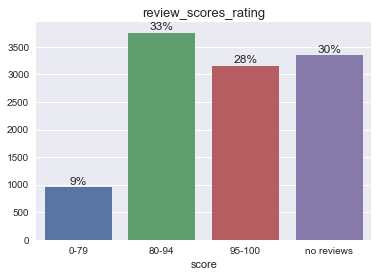

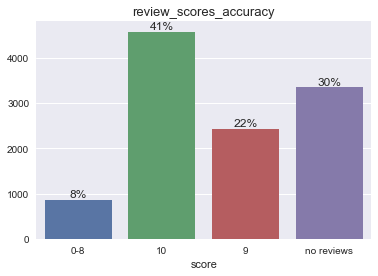

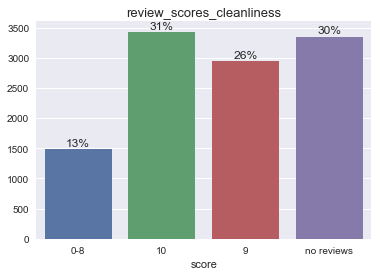

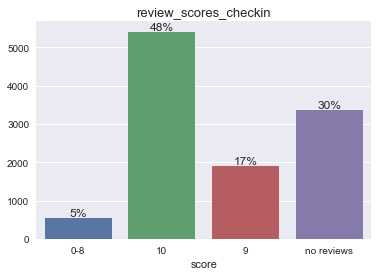

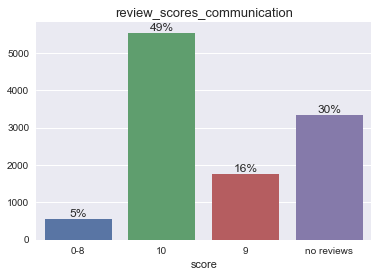

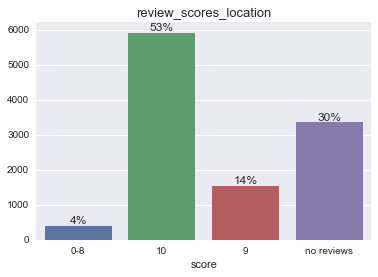

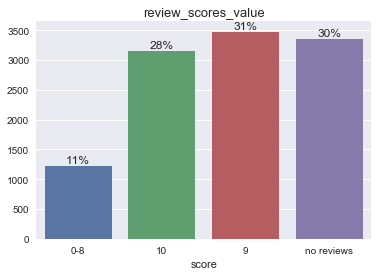

In [89]:
list_review_col = list(listings_final.columns[listings_final.columns.str.startswith("review_scores") == True])
                       
for col in list_review_col:
    review_count_plot(col)

About 61% of listings had received overall rating score over 80, with 28% had received score 95 or above.

30% of listings, however, had not yet been reviewed.

For each review subcategory (incl. rating, accuracy, cleaniness, check-in, communication, location) except "value", rating of 10 (full score) shared the largest portion among others, whereas ratings of 0-8 were rare. Guests seem to be most satisfied about location, check-ins and communication, but more conservative to rate high score in 'value'. The most common reason is that the outcomes of Airbnb experience are not what they expect to pay for.

### First review & Last reviews

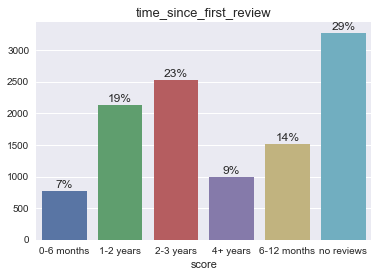

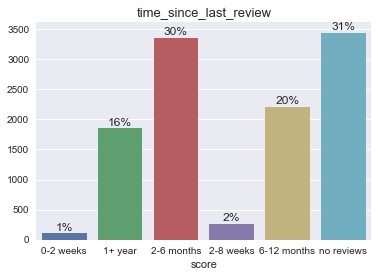

In [90]:
for col in ['time_since_first_review', 'time_since_last_review']:
    review_count_plot(col)

The most common time period in which current Airbnb listings had their first review is 2-3 years. Relatively few have been active for less than 6 months, however.

The most common category for the time since a listing received its last review is 2-6 months. That means a lot of listings have received review recently. The majority of these are probably what are sometimes referred to 'active' listings.  However, there are still around 1.8K listings which have not had a review for more than a year. The majority of these are probably what are sometimes referred to 'inactive' listings, because they are technically live on the site but not available for booking.

As mentioned, about 30% of listings had not yet been reviewed.

### Listings price vs. Districts

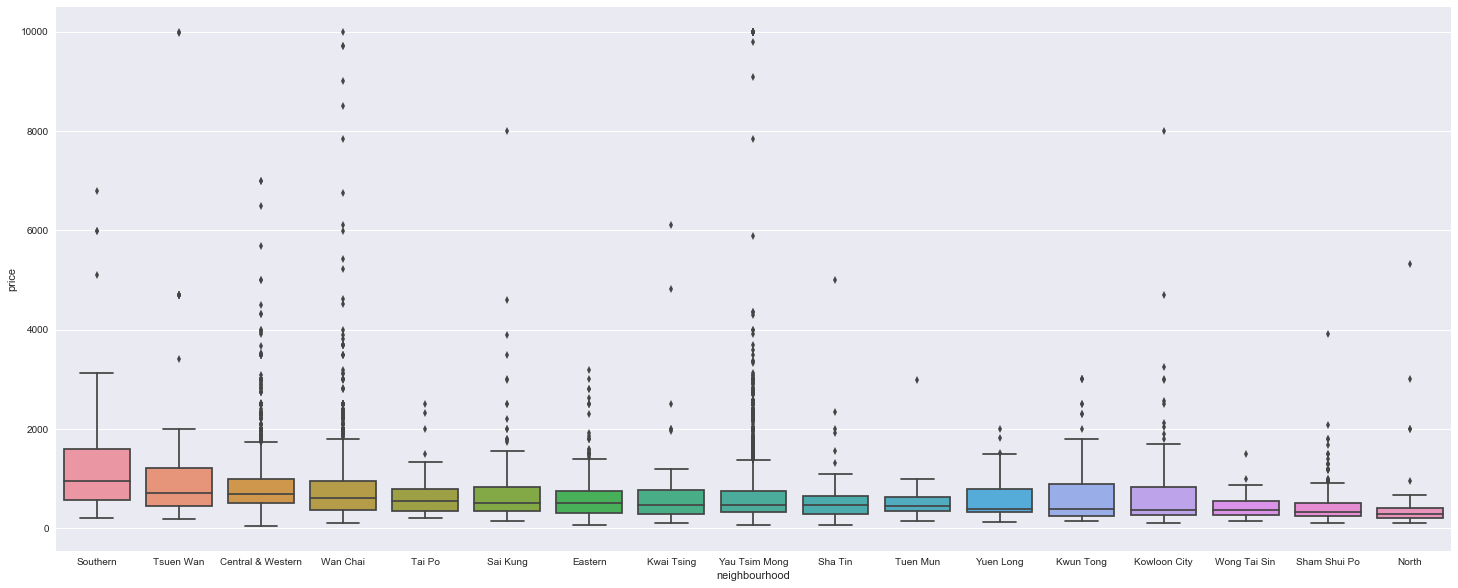

In [91]:
plt.figure(figsize=(25,10))

#Remove outliers (n=59) with price over $10000/night and sort by median price
sorted_median_p = listings_final.loc[(listings_final.price < 10000)].groupby('neighbourhood')['price'].median().sort_values(ascending=False).index

sns.boxplot(y='price', x='neighbourhood', data=listings_final.loc[(listings_final.price < 10000)], order=sorted_median_p);

District with the highest and lowest median price is Southern District (HK\\$960.5) and North District (HK\\$298) respectively. North District also has the fewest number of listings, but Southern District includes 116 listings only.

### Evaluate relationship between Listing's proximity to MTR station and popular Local Venues

In [92]:
#calculate Pearson's correlation
x_array = np.array(listings_final['distance_to_the_nearest_station_KM'])
y_array = np.array(listings_final['avg_walking_mins_to_top5_neighhourhood_venues'])

corr, _ = pearsonr(x_array, y_array)
print('Pearsons correlation: %.2f' % corr)

Pearsons correlation: 0.40


It is not surprising that two location features are positively correlated and that the correlation is 0.40, implying the apartment closer to the popular venues in the district is often closer to the MTR station.

In [93]:
#calculate Pearson's correlation
x_array = np.array(listings_final['avg_walking_mins_to_top5_neighhourhood_venues'])
y_array = np.array(listings_final['price'])

corr, _ = pearsonr(x_array, y_array)
print('Pearsons correlation: %.2f' % corr)

Pearsons correlation: -0.01


The listing price, however, do not have significant correlations with proximity to popular venues in the district.

### How price changes over the year by month?

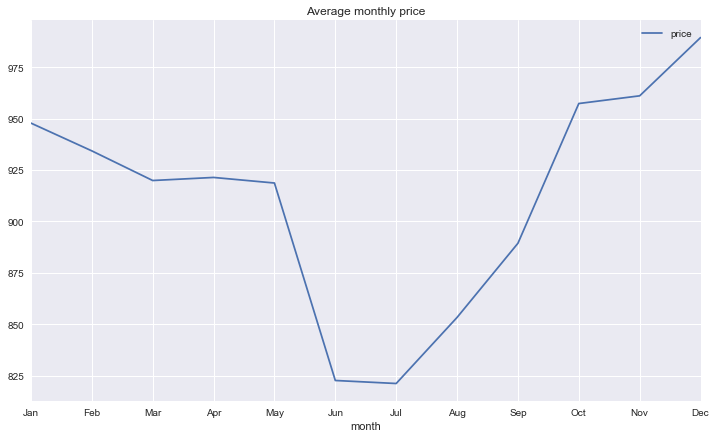

In [94]:
#create month index dict for mapping
month_index_mapping = {v: k for k,v in enumerate(calendar.month_abbr)}

#create new column for month and month index
#'%b' => use the abbriviation of month
calendar_df['month'] = calendar_df['date'].dt.strftime('%b')
calendar_df["month_index"] = calendar_df['month'].map(lambda x: month_index_mapping[x])

#group by month and month index
mean_of_month = calendar_df.groupby([calendar_df['month'],calendar_df['month_index']])['price'].mean().reset_index()

#sort by month index
mean_of_month.sort_values('month_index', inplace=True)
mean_of_month = mean_of_month.reset_index(drop=True)

#set 'month' as index
mean_of_month.set_index('month',inplace=True)

#drop 'month_index' column
mean_of_month.drop('month_index', axis=1, inplace=True)

#Plot Bar Chart
mean_of_month.plot(kind = 'line', figsize = (12,7))

#customize xlabel text and title
plt.xticks(np.arange(12), calendar.month_abbr[1:13])
plt.title('Average monthly price');

The Airbnb average price in Hong Kong fell sharpyly in June and July, then bounced back in the coming months until December. In hindsight, presumably such price cut during summer vacation is due to fierce competition, whereas strong demand for short-stay lodging during the holiday season stimulated surging price before December.

Let's further check if any seasonality pattern is found from the figures of new-joined Airbnb hosts.

### Seasonality of new hosts joining Airbnb?

A given time series consists of three systematic components (i.e. can be modeled) including level, trend, seasonality, and one non-systematic component (i.e. cannot be modeled) called noise/residual.

In [95]:
#Time-series analyis coding reference: https://github.com/L-Lewis/Airbnb-neural-network-price-prediction/blob/master/Airbnb-price-prediction.ipynb

#Creating dataframes for time series analysis
ts_host_since = pd.DataFrame(listings_final.set_index('host_since').resample('MS').size())
ts_first_review = pd.DataFrame(listings_final.set_index('first_review').resample('MS').size())

#Renaming columns
ts_host_since = ts_host_since.rename(columns={0: 'hosts'})
ts_host_since.index.rename('month', inplace=True)
ts_first_review = ts_first_review.rename(columns={0: 'reviews'})
ts_first_review.index.rename('month', inplace=True)

In [96]:
def decompose_time_series(df, title=''):
    """
    Plots the original time series and its decomposition into trend, seasonal and residual.
    """
    # Decomposing the time series
    decomposition = seasonal_decompose(df)
    
    # Getting the trend, seasonality and noise
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Plotting the original time series and the decomposition
    plt.figure(figsize=(12,8))
    plt.suptitle(title, fontsize=14, y=1)
    plt.subplots_adjust(top=0.80)
    plt.subplot(411)
    plt.plot(df, label='Observed')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='upper left')
    plt.tight_layout()

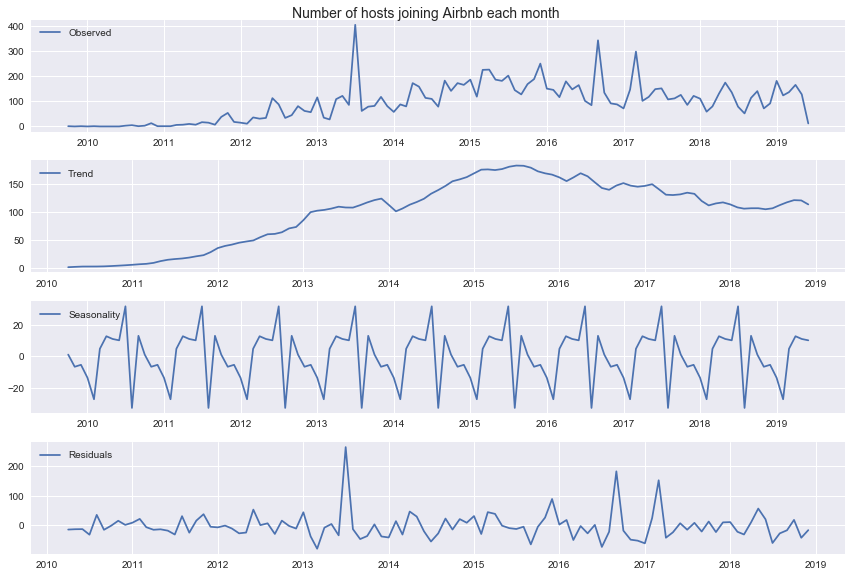

In [97]:
decompose_time_series(ts_host_since, title='Number of hosts joining Airbnb each month')

The seasonality pattern was evident: number of new hosts reached the peak level before summer holiday, followed by a steep fall during July and August. The pattern repeated within a given year, every year.

The above finding implies that many new hosts had joined before summer holiday and offer competitive pricing during the time.

### Commerical operation running by Airbnb host?

Some may argue that the so-called Airbnb 'sharing economy' is actually commercial operations rather than individuals renting a spare room or apartment by Airbnb host. Let's check whether this allegation is valid or not.

In [98]:
print(f"{int(round(100*len(listings_final[listings_final.host_listings_count >= 5])/len(listings_final)))}% of listings were from hosts with at least 5 listings.")
print(f"{int(round(100*len(listings_final[listings_final.host_listings_count == 1])/len(listings_final)))}% of listings were from hosts with one listing only.")

51% of listings were from hosts with at least 5 listings.
30% of listings were from hosts with one listing only.


In [99]:
# List of the top 5 host with the most number of listings on Airbnb
listings_final.sort_values('host_listings_count').drop_duplicates('host_id')[['host_id', 'host_since', 'host_listings_count']].reset_index(drop=True).tail()

,host_id,host_since,host_listings_count
4911,138649185,2017-07-05,145.0
4912,122131447,2017-03-23,147.0
4913,156409670,2017-10-27,150.0
4914,97240131,2016-09-29,219.0
4915,7518056,2013-07-16,343.0


It is undeniable to say that many hosts are hosting a large number of listings under single identity. Based on our cleansed dataset (n=11216), 51% of Airbnb listings in Hong Kong belonged to hosts renting at least 5 rooms or apartments, and only 30% of listings were from hosts renting one room or apartment only. For example, 'Jovee', the largest host who had joined Airbnb since Jul-2013, had managed 343 listings under the name 'Jovee', while the second largest is called 'Jov', managing 219 listings. From their host name, it casts doubt on same identity association.

As almost half of listings were from hosts renting with at least 5 properties, we can conclude that these are commercial operations rather than individuals renting a spare room.

# (8) Final step before modeling: Removing features with Multicollinearity features and rescaling variables

Multicollinearity exists when at least some of the dependent variables are correlated among themselves. As a result, it makes us difficult to ascertain importantance of of features to the target variable and affect model's performance. Removing multicollinearity can also make the model less complex for generalization purpose. Therefore, it is important to run multicollinearity detection before building regression model.

### Drop the variables that we no longer need for modeling

In [100]:
#Set 'id' as index
listings_final.set_index('id', inplace=True) # ID as index

#Drop variables no longer needed
to_drop = ['latitude', 'longitude', 'host_id', 'host_since','amenities',
           'nearest_mtr_station', 'walking_mins_to_the_nearest_station',
           'first_review', 'avg_walking_mins_to_top5_neighhourhood_venues']

listings_final.drop(to_drop, axis=1, inplace=True)

### Create dummy variables for categorical fields

In [101]:
#One Hot Encoding (converting to dummy variable) for categorical variables
listings_final = pd.get_dummies(listings_final)

#drop neighbourhood variables
listings_final.drop(list(listings_final.filter(regex='^neighbourhood').columns), axis=1, inplace=True)

# move target predictor 'price' to the end of the dataframe
cols = list(listings_final.columns.values)
idx = cols.index('price')
rearrange_cols = cols[:idx] + cols[idx+1:] + [cols[idx]]
listings_final = listings_final[rearrange_cols]

### Identify Highly Correlated Features from correlation matrix

The correlation coefficient has values between -1 to 1. The value closer to 1/-1 implies stronger correlation, or vice versa.

We will identify highly correlated features with absolute correlation value 0.5 or above first. If these variables are highly correlated with each other, then we only need to keep only one of them and drop the rest.

In [102]:
#Create correlation matrix
corr_matrix = listings_final.corr().abs()

#Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

#Find index of feature columns with correlation greater than 0.5
to_drop = [column for column in upper.columns if any(upper[column] > 0.5)]

print(to_drop)

['bedrooms', 'beds', 'guests_included', 'availability_60', 'availability_90', 'availability_365', 'Stove', 'Fire extinguisher', 'Cooking basics', 'Essentials', 'Long term stays allowed', 'Refrigerator', 'Carbon monoxide detector', 'Dishes and silverware', 'Bed linens', 'host_response_time_unknown', 'host_response_time_within an hour', 'host_response_rate_0-49%', 'host_response_rate_100%', 'host_response_rate_90-99%', 'host_response_rate_unknown', 'host_is_superhost_1', 'host_identity_verified_1', 'is_location_exact_1', 'property_type_Other', 'room_type_Private room', 'bed_type_Real Bed', 'instant_bookable_1', 'review_scores_accuracy_0-8', 'review_scores_accuracy_10', 'review_scores_accuracy_9', 'review_scores_accuracy_no reviews', 'review_scores_cleanliness_0-8', 'review_scores_cleanliness_10', 'review_scores_cleanliness_9', 'review_scores_cleanliness_no reviews', 'review_scores_checkin_0-8', 'review_scores_checkin_10', 'review_scores_checkin_no reviews', 'review_scores_communication_0

In [103]:
#Inspect highly correlated variables
high_corr_var = ['accommodates','availability_30','price_per_person',
                 'host_response_time_unknown','host_response_time_a few days or more',
                 'host_response_time_within an hour']

#Correlation with output variable
for var in high_corr_var:
    cor_target = abs(listings_final.corr()[var])

    #Select highly correlated features related to the selected variable
    print(cor_target[cor_target>0.5]) 
    print('---------------')

accommodates       1.000000
bedrooms           0.566149
beds               0.752463
guests_included    0.571989
Name: accommodates, dtype: float64
---------------
availability_30     1.000000
availability_60     0.955251
availability_90     0.913599
availability_365    0.635717
Name: availability_30, dtype: float64
---------------
price_per_person    1.000000
price               0.782096
Name: price_per_person, dtype: float64
---------------
availability_60                      0.510595
availability_90                      0.534759
host_response_time_unknown           1.000000
host_response_time_within an hour    0.545837
host_response_rate_100%              0.541753
host_response_rate_unknown           1.000000
Name: host_response_time_unknown, dtype: float64
---------------
host_response_time_a few days or more    1.000000
host_response_rate_0-49%                 0.744182
Name: host_response_time_a few days or more, dtype: float64
---------------
host_response_time_unknown           

### Summary of multi-collinearity:

(1) 'Beds', 'bedrooms', 'guests_included' are highly correlated with 'accommodates' (number of guests accommodated).

    Number of people accommodated has traditionally been a more high priority search parameter on Airbnb, followed by room details such as number of beds and bedrooms. Therefore, we will only keep 'accomodates' while others will be dropped for modeling.

(2) Unsurprisingly, the four 'availability' variables are highly related to each other. 

    For example, we can see that there is a fairly strong correlation (0.96) between 'availability_30' and 'availability_60'. This is a strong sign of multicollinearity. Therefore, we will only keep 'availability_30' while others will be dropped.
 
(3) 'Stove', 'Dishes and silverware' and 'Microwave' are highly correlated with 'Cooking basics'.

    It shows that kitchenware available in the listings are highly correlated with each other. Therefore, we will only keep 'Cooking basics' as it is the main category of kitchenware.
    
(4) 'Bed linens' is highly correlated with 'Extra pillows and blankets'. 

    The latter one will be dropped.
    
(5) There is fairly strong correlation between 'host_response_time_a few days or more' and 'host_response_rate_0-49%'. The similar correlation is found between 'host_response_time_within an hour' and 'host_response_rate_100%'.             

     Although these are important categories, one of each (i.e. 'host_response_time_a few days or more' and 'host_response_time_within an hour') will be dropped in order to reduce multi-collinearity.
     
(6) Meanwhile, 'host_response_time_unknown' is perfectly correlated with 'host_response_rate_unknown'.

    If no one had ever asked hosts any questions, then both variable values should be unknown. Therefore, one of them will be dropped. 
     
(6) There are strong correlations between 'property_type_Apartment' and 'property_type_Others', and between 'room_type_Private room' and 'room_type_Entire_home_apt'.

     Although these are important categories, one of each (i.e. 'property_type_Others' and 'room_type_Private room') will be dropped in order to reduce multi-collinearity.
    
(7) There are perfect correlations between no reviews (i.e. listings that are not reviewed yet) subcategories, and first and last review times. 

    These 'no review' variables can be dropped altogether.

(8) Boolean variable (e.g. 'instant_bookable_0' vs. 'instant_bookable_1') is highly correlated with each other for the same feature.
    
    One of them for each feature will be dropped.

In [104]:
# Dropping collinear features
to_drop = ['beds',
           'bedrooms',
           'guests_included', 
           'availability_60',
           'availability_90',
           'availability_365',
           'Stove',
           'Dishes and silverware',
           'Microwave',
           'Stove',
           'Dishes and silverware',
           'Microwave',
           'Extra pillows and blankets',
           'host_is_superhost_1',
           'host_identity_verified_1',
           'is_location_exact_1',
           'instant_bookable_1',
           'host_response_time_unknown',
           'host_response_time_a few days or more',
           'host_response_time_within an hour',
           'property_type_Other',
           'room_type_Private room'
          ]
to_drop.extend(list(listings_final.columns[listings_final.columns.str.endswith('no reviews')]))

listings_final.drop(to_drop, axis=1, inplace=True)

### Final assessment of multi-collinearity using correlation matrix heatmap

In [105]:
def multi_collinearity_heatmap(df, figsize=(30,30)):
    
    """
    Creates a heatmap of correlations between features.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(200, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

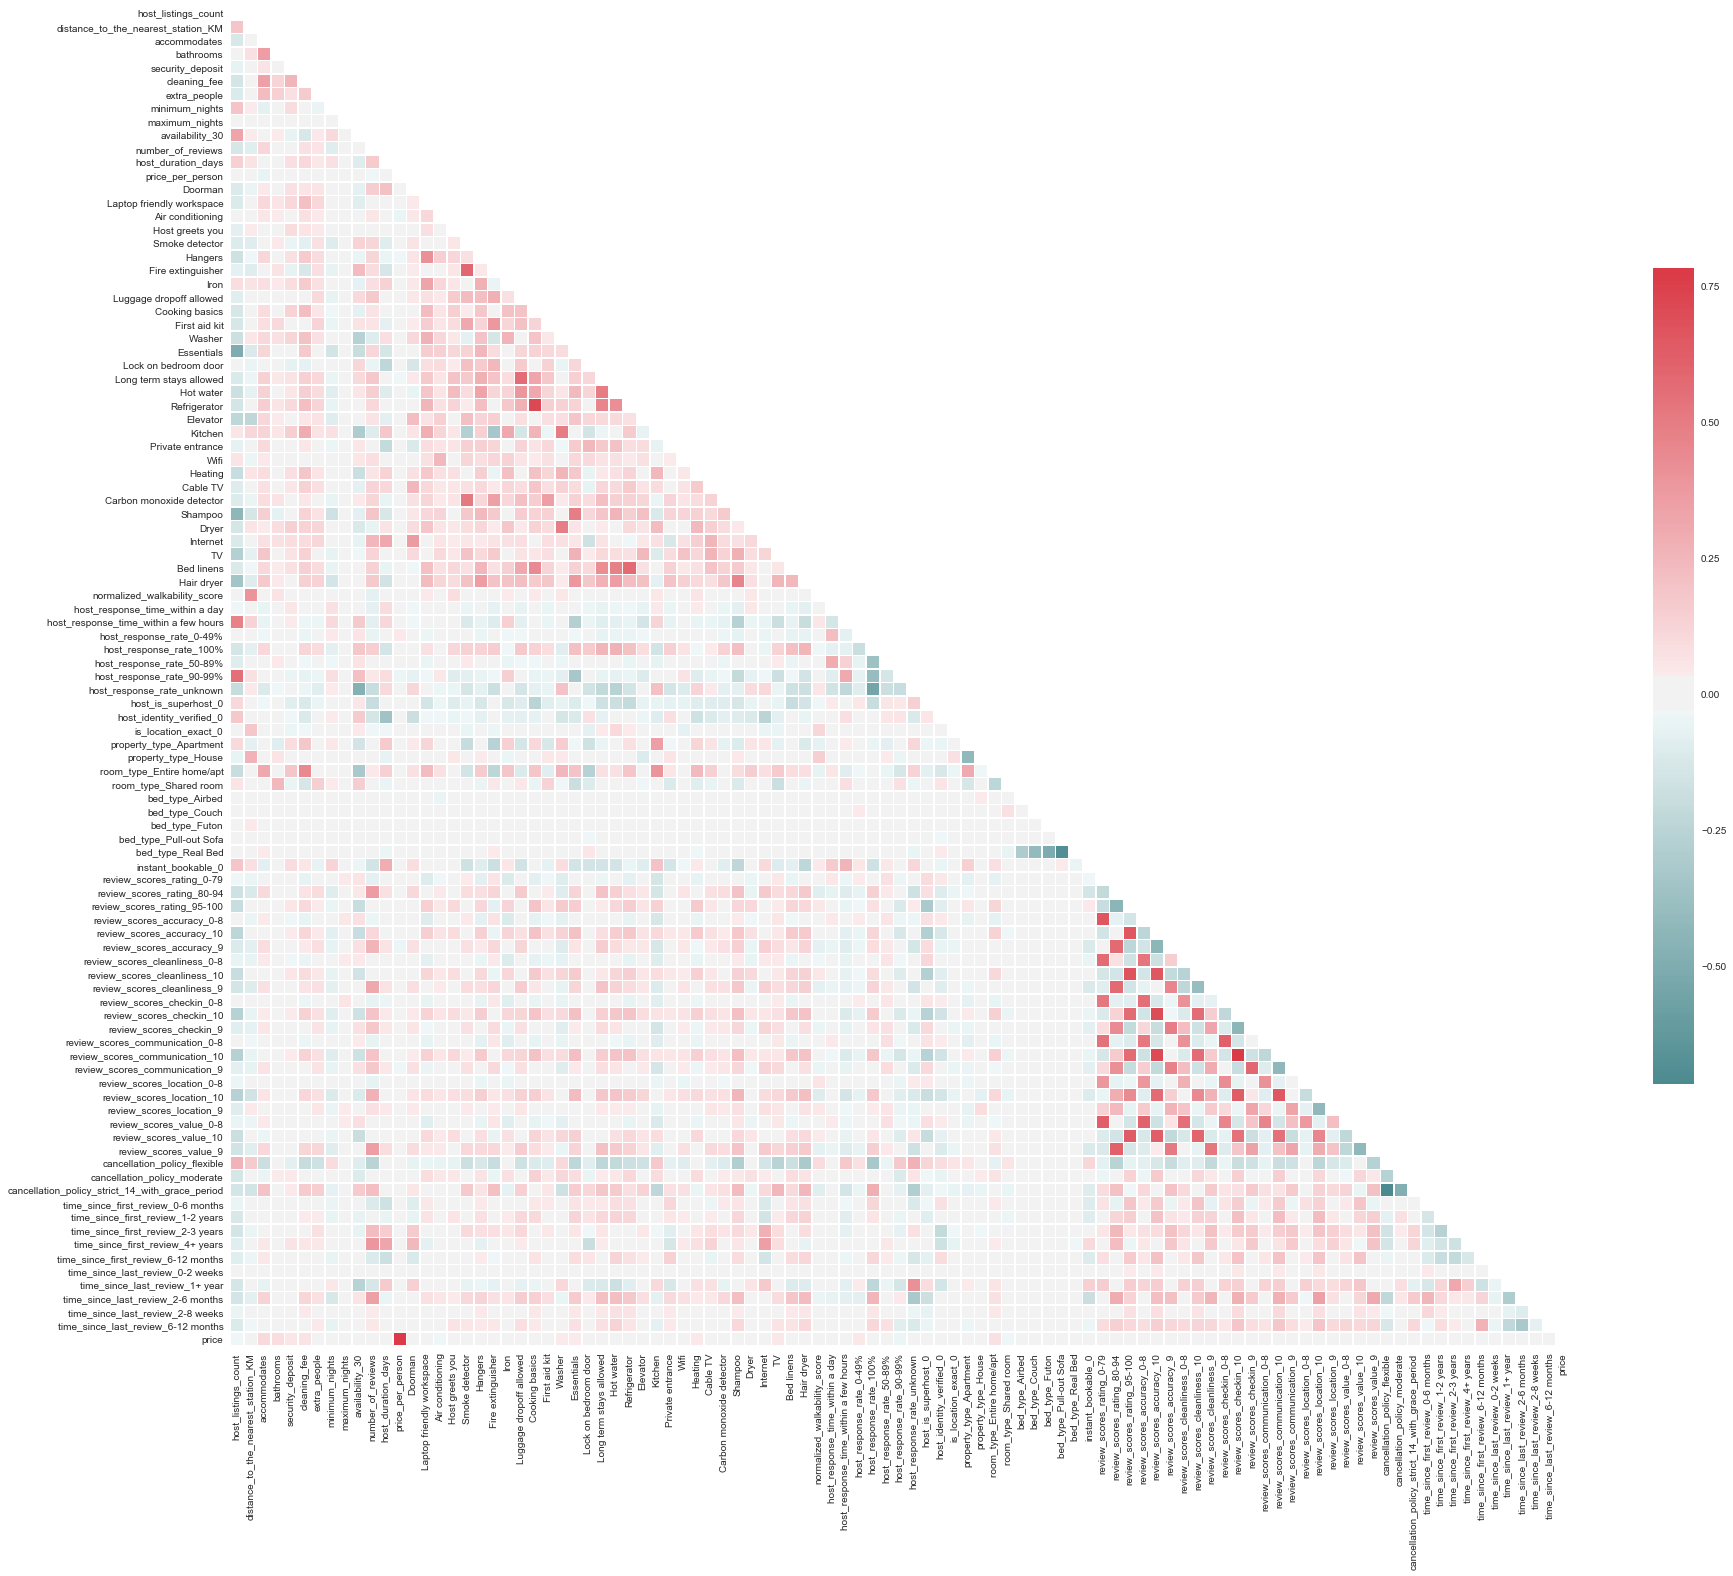

In [106]:
multi_collinearity_heatmap(listings_final)

From the above heatmap, we can still see:

(1) 'price' is obviously highly correlated with 'price_per_person'.

    The latter one will be dropped.

(2) 'Cooking basics' is still highly correlated with 'Refrigerator'.

    The latter one will be dropped.
    
(3) 'Smoke detector' is still highly correlated with 'Fire extinguisher'.

    The latter one will be dropped.
    
(4) a highly correlation 'cancellation_policy_flexible' and 'cancellation_policy_strict_14_with_grace_period'.

    Again, the latter one will be dropped.

(5) a highly correlation between 'Luggage dropoff allowed' and 'Long term stays allowed'.
    
    Apartment available for long term stay usually allow guest to drop off luggage. Again, the latter one will be dropped.
    
(6) There are still fairly strong correlations between highly rated properties of different reviews subcategories - i.e. if a property gets score 9-10 score for overall rating, it is likely to score 9-10 for other review categories. 
    
    Review score subcategories will be dropped and see if removing them improves the model.

In [107]:
# Dropping collinear features
to_drop_further = ['price_per_person',
                   'Refrigerator',
                   'cancellation_policy_strict_14_with_grace_period',
                   'Long term stays allowed',
                   'Smoke detector'
                  ]

to_drop_further.extend(list(listings_final.filter(regex='^review_scores_accuracy').columns))
to_drop_further.extend(list(listings_final.filter(regex='^review_scores_cleanliness').columns))
to_drop_further.extend(list(listings_final.filter(regex='^review_scores_checkin').columns))
to_drop_further.extend(list(listings_final.filter(regex='^review_scores_location').columns))
to_drop_further.extend(list(listings_final.filter(regex='^review_scores_communication').columns))
to_drop_further.extend(list(listings_final.filter(regex='^review_scores_value').columns))
                       
listings_final.drop(to_drop_further, axis=1, inplace=True)

Instead of plotting correlation matrix for checking multicollinearity, we can simply measure which features have the correlation coefficient above 0.5 and then remove them from the dataset.

In [108]:
correlated_features = set()
correlation_matrix = listings_final.drop('price', axis=1).corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.5:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

#Drop highly correlated features
listings_final.drop(correlated_features, axis=1, inplace=True)            
print(correlated_features)

{'host_response_rate_unknown', 'host_response_rate_90-99%', 'bed_type_Real Bed', 'Essentials'}


Finally, 'bed_type_Real Bed', 'Essentials', 'host_response_rate_unknown' and 'host_response_rate_90-99%' features will be dropped.

### Test of skewness and kurtosis

Skewness is used to describe the degree of asymmetry of data. If the input data is too deviate from (Gaussian) distribution, it will seriously affect model performance such as linear regression and reduce the models from varying widely.

Kurtosis is a statistical measure used to describe the "tailedness" of the probability distribution. If the kurtosis is above zero, the distribution has a marked peak. If it is below zero, the distribution is too flat instead.

When performing the skewness and kurtosis tests, if p-value is less than 0.05, it implies normality assumption is rejected and we could obtain better results after feature scaling. In our study, log transformation and standardization method will be used to perform scaling transformation of the interval variables.

Skewness score: 

host_listings_count:      skewness 3.504  z-score 76.458  p-value 0.000
distance_to_the_nearest_station_KM:      skewness 5.383  z-score 91.369  p-value 0.000
accommodates:      skewness 2.461  z-score 64.420  p-value 0.000
bathrooms:      skewness 6.097  z-score 95.727  p-value 0.000
price:      skewness 30.783  z-score 152.830  p-value 0.000
security_deposit:      skewness 9.053  z-score 109.618  p-value 0.000
cleaning_fee:      skewness 3.872  z-score 79.898  p-value 0.000
extra_people:      skewness 5.138  z-score 89.742  p-value 0.000
minimum_nights:      skewness 21.357  z-score 139.910  p-value 0.000
maximum_nights:      skewness 74.864  z-score 184.251  p-value 0.000
availability_30:      skewness -0.051  z-score -2.204  p-value 0.028
number_of_reviews:      skewness 3.553  z-score 76.935  p-value 0.000
host_duration_days:      skewness 0.105  z-score 4.534  p-value 0.000
normalized_walkability_score:      skewness 4.842  z-score 87.668  p-value 0.000
--------

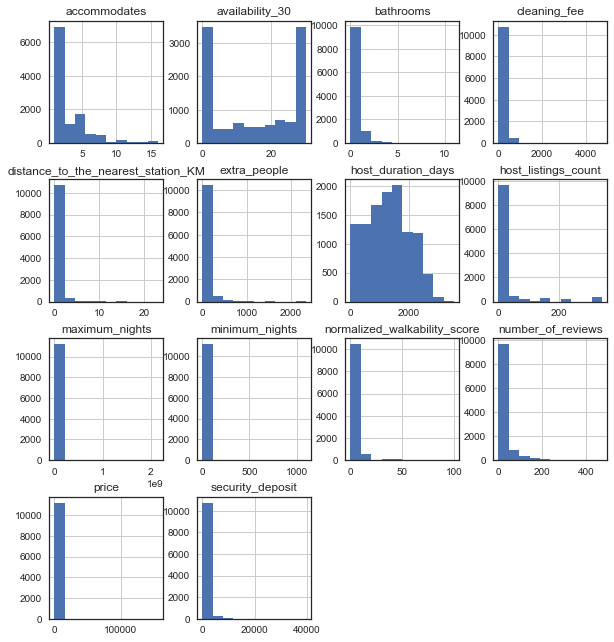

In [109]:
interval_var = ['host_listings_count','distance_to_the_nearest_station_KM','accommodates',
                'bathrooms','price','security_deposit','cleaning_fee','extra_people',
                'minimum_nights','maximum_nights','availability_30','number_of_reviews',
                'host_duration_days','normalized_walkability_score']

#visualizing distribution of interval variable
listings_final[interval_var].hist(figsize=(10,11));

#test skewnwss
print('Skewness score: \n')
for var in interval_var:
    s = skew(listings_final[var])
    zscore, pvalue = skewtest(listings_final[var])
    print('{}:      skewness %0.3f  z-score %0.3f  p-value %0.3f'.format(var) % (s, zscore, pvalue))

#test kurtosis
print('------------------')
print('Kurtosis score: \n')
for var in interval_var:
    k = kurtosis(listings_final[var])
    zscore, pvalue = kurtosistest(listings_final[var])
    print('{}:      kurtosis %0.3f  z-score %0.3f  p-value %0.3f'.format(var) % (k, zscore, pvalue))

### Log Transformation

Other than 'availability_30' and 'host_duration_days', the remaining numerical features are all postively skewed and could benefit from log transformation.

In [110]:
#Log transforming columns
for col in interval_var:
    listings_final[col] = np.log(listings_final[col] + 1)
    listings_final.rename(columns={col: 'log_' + str(col)},inplace=True)

In [111]:
#raname item in 'interval_var' list with prefix 'log_'
interval_var = ['log_host_listings_count','log_distance_to_the_nearest_station_KM','log_accommodates',
                'log_bathrooms','log_security_deposit','log_cleaning_fee','log_extra_people',
                'log_minimum_nights','log_maximum_nights','log_availability_30','log_number_of_reviews',
                'log_host_duration_days','log_normalized_walkability_score']

### Standardization

Then we applied ‘Standardization’ to rescale the values so that the distribution standard deviation from the mean equals one. As such, each variable can be treated equally in the model.

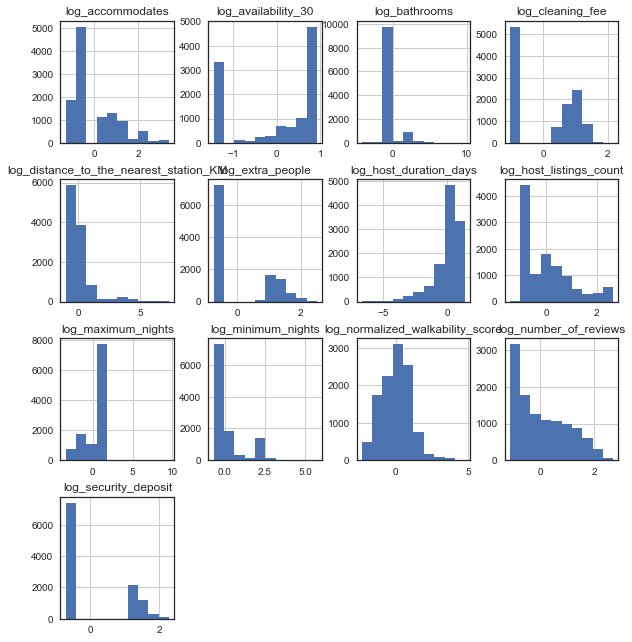

In [112]:
#Convert non-categorical variables to floats and standardize
def standardize_col(col):
    mean = np.mean(col)
    std = np.std(col)
    return col.apply(lambda x: (x - mean) / std)

for col in interval_var:
    listings_final[col] = listings_final[col].astype('float')
    listings_final[col] = standardize_col(listings_final[col])
    
listings_final[interval_var].hist(figsize=(10,11));

In [113]:
#Export cleansed listings datasets
listings_final.to_csv('listings(cleansed)' + '.csv', index = False)

# (9) Modeling

Lasso, Ridge, KNN, Decision Tree, Gradient Boost, Random Forest and Extra Tree model will be generated to compare with Ordinary Linear Regression (our base model), so eight models in total. 

The goal is to compare the out-of-sample forecasting performance for the unseen test data (OOS MSE) in order to determine weather our model is well generalised.

K-fold cross-validation is used for the model selection using training data, and evaluate the performance using testing data.

### Feature Selection Approach: Recursive Feature Elimination with Cross-Validation (RFECV)

Recursive feature elimination (RFE) is basically a backward feature selection method that fits a model and removes the weakest feature (or features) until the specified number of features is reached. This technique begins by building a model on the entire set of predictors and computing an importance score for each predictor. The least important predictor(s) are then removed, the model is re-built, and importance scores are computed again.

This process is applied until all features in the dataset are exhausted. For RFECV, features are then ranked with recursive feature elimination via a cross validation loop. As such, The optimal subset is then used to train the final model.

In [114]:
#Separating X and y
X = listings_final.drop(['log_price'], axis=1)
y = listings_final['log_price']

In [115]:
#use linear regression as the model
ols = LinearRegression()

# Create recursive feature eliminator that scores features by (negated version of) mean squared error
rfecv = RFECV(estimator=ols, step=1, cv=KFold(3), scoring='neg_mean_squared_error')

# Fit recursive feature eliminator 
rfecv.fit(X, y)

# Recursive feature elimination
rfecv.transform(X)

#Number of best features remained to produce the best accuracy 
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 61


The support array of rfecv indicates the importance of these features. So we can just filter 'False' in importance array to find out which features are not important.

In [116]:
df = pd.DataFrame({'feature': list(X.columns),'importance': rfecv.support_})
df.loc[df['importance'] == False]

,feature,importance
5,log_cleaning_fee,False
8,log_maximum_nights,False
13,Laptop friendly workspace,False
19,Luggage dropoff allowed,False
23,Lock on bedroom door,False
36,Bed linens,False
37,Hair dryer,False
44,host_is_superhost_0,False
46,is_location_exact_0,False
62,time_since_first_review_1-2 years,False


Drop 10 more features which are considered to be least important:
- log_cleaning_fee
- log_maximum_nights
- Lugguage dropoff allowed
- Hair dryer
- Bed linens
- Laptop friendly workspace
- Lock on bedroom door
- host_is_superhost_0
- is_location_exact_0
- time_since_first_review_1-2 years

In [117]:
X.drop(X.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)

Let's plot a Bar chart to visualize feature importances:

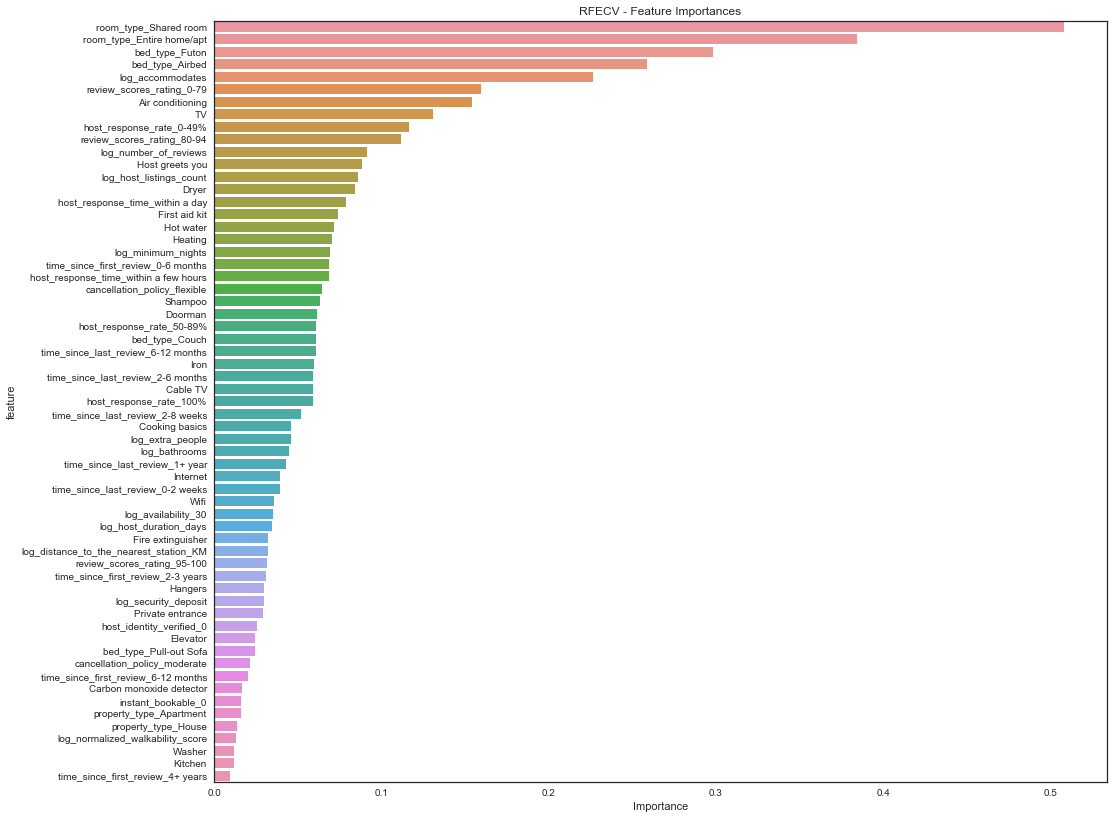

In [118]:
#Create a DataFrame object with features as one column and the importance as the other
#then just simply sort the DataFrame by importance in descending order. 

feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns
feature_importances['importance'] = np.absolute(rfecv.estimator_.coef_)
feature_importances = feature_importances.sort_values(by='importance', ascending=False).reset_index(drop=True)

#Plot a Bar chart to visualize feature importances
f, ax = plt.subplots(figsize=(16, 14))

sns.barplot(data=feature_importances, x = 'importance', y = 'feature')

ax.set_title("RFECV - Feature Importances")
ax.set_xlabel('Importance');

### Run a log-linear regression as our base model

In [119]:
#Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

#Manually add an intercept (beta_0) to our model as statsmodels does not add intercept term automatically 
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test) 

#Fit model to the train set
model = sm.OLS(y_train, X_train).fit()

#then run model predictions on the unseen testing set
predictions = model.predict(X_test)

#print model summary
#model.summary()

Let's keep 40 features with p-values < 0.05 (significant level) and then run the model again.

In [120]:
most_important_features = list(pd.Series(model.pvalues[model.pvalues < 0.05].sort_values()).index[1:])
print(most_important_features)

['log_accommodates', 'room_type_Entire home/apt', 'room_type_Shared room', 'log_host_listings_count', 'TV', 'log_minimum_nights', 'log_number_of_reviews', 'log_bathrooms', 'log_extra_people', 'log_distance_to_the_nearest_station_KM', 'Heating', 'log_host_duration_days', 'Dryer', 'Iron', 'Hot water', 'log_security_deposit', 'host_response_rate_100%', 'Air conditioning', 'log_availability_30', 'Host greets you', 'host_response_rate_0-49%', 'review_scores_rating_0-79', 'First aid kit', 'cancellation_policy_flexible', 'Shampoo', 'host_response_time_within a few hours', 'Internet', 'log_normalized_walkability_score', 'host_response_time_within a day', 'review_scores_rating_80-94', 'Hangers', 'Cable TV', 'Doorman', 'time_since_first_review_2-3 years', 'Private entrance', 'time_since_first_review_0-6 months', 'host_response_rate_50-89%', 'Cooking basics', 'host_identity_verified_0', 'bed_type_Futon']


In [121]:
X = X[most_important_features] #keep most important feature in dataset

#Split data into train and test sets (7:3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

#Manually add an intercept (beta_0) to our model as statsmodels does not add intercept term automatically 
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test) 

#Fit model to the train set
model = sm.OLS(y_train, X_train).fit()

#then run model predictions on the unseen data set
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

#drop constant after modeling
X_train = X_train.drop(['const'], axis=1)
X_test = X_test.drop(['const'], axis=1)

#print model summary
results_summary = model.summary()
results_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.453
Method:                 Least Squares   F-statistic:                     163.6
Date:                Sun, 12 Jan 2020   Prob (F-statistic):               0.00
Time:                        18:44:07   Log-Likelihood:                -6336.3
No. Observations:                7851   AIC:                         1.275e+04
Df Residuals:                    7810   BIC:                         1.304e+04
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                      6.2028      0.045    136.447      0.000       6.114       6.292
log_accommodates                           0.2222      0.008     27.488      0.000       0.206       0.238
room_type_Entire home/apt                  0.3761      0.016     23.483      0.000       0.345       0.407
room_type_Shared room                     -0.5295      0.030    -17.862      0.000      -0.588      -0.471
log_host_listings_count                   -0.0846      0.008    -10.077      0.000      -0.101      -0.068
TV                                         0.1452      0.015      9.477      0.000       0.115       0.175
log_minimum_nights                        -0.0763      0.008     -9.343      0.000      -0.092      -0.060
log_number_of_reviews                     -0.0953      0.009    -10.200      0.000      -0.114      -0.077
log_bathrooms                              0.0474      0.007      6.969      0.000       0.034       0.061
log_extra_people                          -0.0459      0.007     -6.336      0.000      -0.060      -0.032
log_distance_to_the_nearest_station_KM     0.0339      0.007      5.062      0.000       0.021       0.047
Heating                                    0.0785      0.016      5.039      0.000       0.048       0.109
log_host_duration_days                     0.0374      0.007      5.007      0.000       0.023       0.052
Dryer                                      0.0951      0.016      6.032      0.000       0.064       0.126
Iron                                       0.0651      0.014      4.681      0.000       0.038       0.092
Hot water                                 -0.0640      0.015     -4.312      0.000      -0.093      -0.035
log_security_deposit                       0.0304      0.007      4.356      0.000       0.017       0.044
host_response_rate_100%                    0.0788      0.017      4.738      0.000       0.046       0.111
Air conditioning                          -0.1702      0.040     -4.266      0.000      -0.248      -0.092
log_availability_30                        0.0343      0.008      4.426      0.000       0.019       0.049
Host greets you                            0.0772      0.020      3.938      0.000       0.039       0.116
host_response_rate_0-49%                   0.1509      0.038      3.966      0.000       0.076       0.226
review_scores_rating_0-79                 -0.1189      0.024     -5.055      0.000      -0.165      -0.073
First aid kit                             -0.0541      0.016     -3.334      0.001      -0.086      -0.022
cancellation_policy_flexible              -0.0642      0.017     -3.837      0.000      -0.097      -0.031
Shampoo                                    0.0693      0.018      3.754      0.000     

In [122]:
#Check the predictions against the actual values by using the RMSE and R-square metrics:
print('Performance of OLS (the simplist method we can think about):')
print('-------------------------------------------------')

print("Training RMSE:", round(np.sqrt(mean_squared_error(y_train, train_pred)),3))
print("Training R_Squared:", round(r2_score(y_train, train_pred),3))


print("\nTesting RMSE:", round(np.sqrt(mean_squared_error(y_test, test_pred)),3))
print("Testing R_Squared:", round(r2_score(y_test, test_pred),3))

Performance of OLS (the simplist method we can think about):
-------------------------------------------------
Training RMSE: 0.542
Training R_Squared: 0.456

Testing RMSE: 0.523
Testing R_Squared: 0.455


### K-fold Cross-Validation: Regression models comparison

We will use different regression models offered by scikit-learn to produce a baseline accuracy for this problem. We will use the RMSE (Root Mean Squared Error) as the performance metric for the regression models.

Here, the data set is split into 10 folds for fitting each model. In the first iteration, the first fold is used to test the model and the rest are used to train the model. In the second iteration, 2nd fold is used as the testing set while the rest serve as the training set. This process is repeated until each fold of the 10 folds have been used as the testing set.

The performance measure reported by k-fold cross-validation is then the average of MSE scores (10 scores in total) computed in the loop. Finally, we will further convert MSE into RMSE as the metric for comparing multiple regression models.

In [123]:
folds   = 10                        #split dataset into k consecutive folds. Each fold is then used once as a validation while the k - 1 remaining folds form the training set.
metric  = 'neg_mean_squared_error'  #model evaluation metric
parameters = {'alpha': [0.005, 0.05, 0.03, 0.1,1,5,10,20]} #the lower constraint (i.e. lower λ) on the features, the model is less penalized by coefficients and thus resemble linear regression model

#hold different regression models in a single dictionary
models = {}
models["Linear"]        = LinearRegression()
models["Ridge"]         = Ridge()
models["Lasso"]         = Lasso()
models["KNN"]           = KNeighborsRegressor()
models["DecisionTree"]  = DecisionTreeRegressor()
models["GradientBoost"] = GradientBoostingRegressor()
models["RandomForest"]  = RandomForestRegressor()
models["ExtraTrees"]    = ExtraTreesRegressor()

#10-fold cross validation for each model
model_results = []
model_names   = []

for model_name in models:
    model  = models[model_name]
    k_fold = KFold(n_splits=folds, random_state=100)
    
    #search for optimal value of alpha (λ) hyperparameter by cross-validated grid-search over a parameter grid
    if model_name in {'Ridge','Lasso'}:
        model_regressor = GridSearchCV(model, param_grid=parameters, cv=k_fold, scoring=metric)
        model_regressor.fit(X_train, y_train)
        results = model_regressor.best_score_
        
        if model_name == 'Ridge':
            model_name = 'Ridge (alpha={})'.format(model_regressor.best_estimator_.alpha) #grab the optimal value of alpha
        else:
            model_name = 'Lasso (alpha={})'.format(model_regressor.best_estimator_.alpha)
            
    else:
        scores = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=metric) #return an array of scores for each loop
        mse_scores = -scores              #fix the sign of MSE scores
        rmse_scores = np.sqrt(mse_scores) #convert from MSE to RMSE
        rmse_scores = rmse_scores.mean()  #calculate mean score of RMSE
        
    model_results.append(rmse_scores)
    model_names.append(model_name)

#To zip 2 lists together and then construct dataframe    
list_of_tuples = list(zip(model_names, model_results))
df = pd.DataFrame(list_of_tuples, columns = ['Model', 'cv_RMSE'])
df

,Model,cv_RMSE
0,Linear,0.545315
1,Ridge (alpha=10),0.545315
2,Lasso (alpha=0.005),0.545315
3,KNN,0.504417
4,DecisionTree,0.641082
5,GradientBoost,0.499474
6,RandomForest,0.481418
7,ExtraTrees,0.492048


### MSE should be positive, but why is the MSE here negative?

Answer: 
MSE is a loss function which is something we want to minimize. A design decision was made so that the results are made negative. The best results would be the largest number (the least negative) so we can still maximize similar to classification accuracy.

Reference: https://www.ritchieng.com/machine-learning-cross-validation/

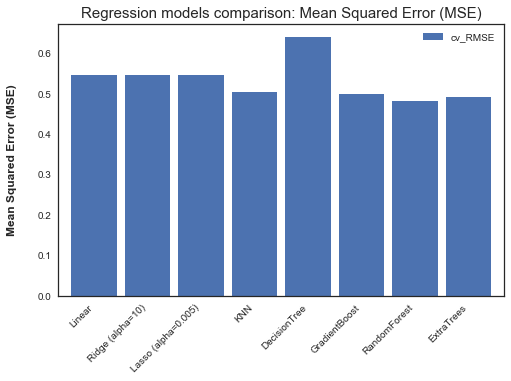

In [124]:
#Create bar chart to compare regression model performance
ax = df.plot(kind='bar', figsize=(8, 5), zorder=2, width=0.85)

#Add title
plt.title('Regression models comparison: Mean Squared Error (MSE)', fontsize=15)

#Set x-axis tick labels
ax.set_xticklabels(df['Model'], rotation = 45, ha="right")

# Set y-axis labels
ax.set_ylabel("Mean Squared Error (MSE)", labelpad=20, weight='bold', size=12)

plt.savefig("model_mse_scores.png")

Based on the above comparison, we can see that Random Forest Regression model outperforms all the other regression models. Therefore, we will adopt it as our final regression model for predicting Airbnb price in the unseen testing dataset.

In [125]:
#Create and fit the best regression model (Random Forest)
best_model = RandomForestRegressor(random_state=100)
best_model.fit(X_train, y_train)

#Make predictions using testing data
predictions = best_model.predict(X_test)
print('Performance of Random Forest Regression Model:')
print('-------------------------------------------------')
print('Testing RMSE : {}'.format(round(np.sqrt(mean_squared_error(y_test, predictions)), 3)))
print('Testing R_Squared:', round(r2_score(y_test, predictions),3))

Performance of Random Forest Regression Model:
-------------------------------------------------
Testing RMSE : 0.48
Testing R_Squared: 0.54


Finally, we can see that Random Forest model achieved RMSE of 0.48 with R-squared 0.54, implying 54% of variations of price can be explained by our model. 

Since we have transformed price into log price in data preprocessing step, RMSE should not wrongly interprete as absolute differences between actual values and the predicted values.

In conclusion, Random Forest Model is regarded as our best model to beat OLS (benchmark model).

### Exploring Feature importances with Random Forests model

In [126]:
#Get numerical feature importances
importances = list(best_model.feature_importances_)

#List of tuples with variable and importance
feature_list = list(X_test.columns)

#To zip 2 lists together and then construct dataframe  
list_of_tuples = list(zip(feature_list, importances))
variable_importance_df = pd.DataFrame(list_of_tuples, columns = ['Variable', 'Importance'])
variable_importance_df.sort_values('Importance', ascending = False, inplace = True)

#Keep top 10 features only
sorted_importance = variable_importance_df[:10]

#Print the feature ranking and cumulative importances
print('Cumulative importances of top 10 features: {}'.format(sum(sorted_importance['Importance'])))

sorted_importance

Cumulative importances of top 10 features: 0.7660627681356608


,Variable,Importance
1,room_type_Entire home/apt,0.244478
0,log_accommodates,0.102947
3,log_host_listings_count,0.089487
27,log_normalized_walkability_score,0.075467
11,log_host_duration_days,0.051661
7,log_bathrooms,0.046323
9,log_distance_to_the_nearest_station_KM,0.044197
18,log_availability_30,0.041560
6,log_number_of_reviews,0.036937
5,log_minimum_nights,0.033006


Out of 40 features included in the model, we can see that there are some key features affecting airbnb pricing:

- Room Type (Entire Home/Apartment)
- Number of accommodates, host profile (number of listings and host duration on website)
- Location (e.g. walkability to the nearest popular venues and proximity to MTR station)
- Number of bathrooms
- Days available to be booked in the next 30 days 
- Number of reviews of the apartment
- Minimum nights required for booking